In [5]:
install.packages("recipes")

Installation du package dans 'C:/Users/essak/AppData/Local/R/win-library/4.3'
(car 'lib' n'est pas spécifié)



installation de la dépendance 'sparsevctrs'





  Des versions binaires sont disponibles mais les versions des sources
  sont plus récentes:
            binary source needs_compilation
sparsevctrs  0.3.2  0.3.3              TRUE
recipes      1.2.1  1.3.0             FALSE

  Binaries will be installed
le package 'sparsevctrs' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\essak\AppData\Local\Temp\RtmpyKHnMn\downloaded_packages


installation du package source 'recipes'




In [11]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(caret)

# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
#scaler <- scale(gym_train[,-c(2,10,13,14)])
scaler <- scale(gym_train[,-c(2,9,10,13,14)])  # Exclure la colonne Calories_Burned (colonne 9)
# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")


# Appliquer la normalisation uniquement sur les colonnes sélectionnées
gym_train_scaled[,-c(2,9,10,13,14)] <- scale(gym_train[,-c(2,9,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,9,10,13,14)] <- scale(gym_test[,-c(2,9,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

Data loaded and preprocessed

In [7]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned     Workout_Type SFat_Percentage   
 Min.   :-2.20445  

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned      Workout_Type SFat_Percentage   
 Min.   :-2.17545        

### Linear régression


Call:
lm(formula = Calories_Burned ~ ., data = gym_train_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-129.781  -25.798   -2.093   21.929  174.692 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    863.83896    5.84203 147.866   <2e-16 ***
Age                            -41.48959    1.47443 -28.139   <2e-16 ***
GenderMale                      90.90917    5.96339  15.245   <2e-16 ***
LWeight                          2.37302    1.81802   1.305    0.192    
Height..m.                       0.56211    1.79582   0.313    0.754    
Max_BPM                          0.43035    1.48189   0.290    0.772    
Avg_BPM                         90.48059    1.47639  61.285   <2e-16 ***
Resting_BPM                      2.40358    1.47472   1.630    0.104    
Session_Duration..hours.       245.80498    2.40398 102.249   <2e-16 ***
Workout_TypeHIIT                 1.37064    4.18464   0.328    0.743    
Workout_Type

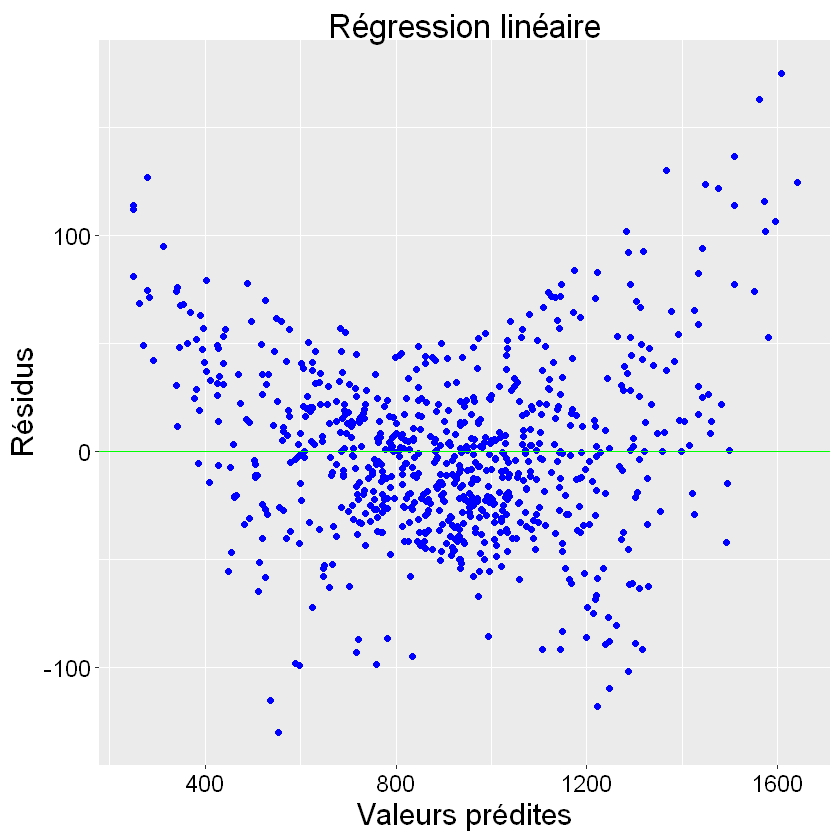

In [12]:
reg.lm <- lm(Calories_Burned ~ ., data = gym_train_scaled)

# Summary of the regression
summary(reg.lm)

# Extract the residuals
sel.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Plot the residuals
gplot.res(fit.lm, sel.lm, "Régression linéaire")

In [13]:
# MSE of the model on the training and test set
mse_train <- mean(sel.lm^2)
mse_test <- mean((predict(reg.lm, gym_test_scaled) - gym_test_scaled$Calories_Burned)^2)

cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")

MSE on training set:  1624.432 


MSE on test set:  1218.783 



### Performance du modèle 
Le modèle linéaire explique 97,8 % de la variance des calories brûlées, ce qui constitue une performance remarquable. Toutefois, un tel résultat peut également être suspect, suggérant un possible surapprentissage, ou bien la présence d’un prédicteur dominant.

En effet, la variable Session_Duration..hours. (coefficient standardisé ≈ 0.893) semble jouer un rôle prédominant dans le modèle. Cela s’explique logiquement : plus une séance dure longtemps, plus la dépense calorique augmente de manière mécanique.

En ce qui concerne les autres coefficients standardisés, on observe que :

- Une augmentation d’1 écart-type de la durée de la séance entraîne une hausse de 0.893 écart-type des calories brûlées.
- Une fréquence cardiaque moyenne élevée est également un bon prédicteur (+0.329 SD).
- À caractéristiques équivalentes, les hommes brûlent en moyenne 0.33 écart-type de calories de plus que les femmes.

À l’inverse, plusieurs variables n’ont pas montré d’effet significatif (p > 0.05), notamment :

- Les caractéristiques physiques telles que le poids (Weight) ou le pourcentage de masse grasse (Fat_Percentage)
- Certains paramètres cardiaques comme le rythme cardiaque maximal ou au repos
- Le type d'entraînement (HIIT, force, yoga), qui semble avoir peu d’influence une fois les autres facteurs contrôlés.


En ce qui est du graphe des résidus: 

La forme en banane des résidus nous fait dire que le modèle ne capture pas entièrement les relations non linéaires entre variables malgré la valeur assez élevée du score R² (97,85%)





Nous allons maintenant étudier l’effet des interactions entre les variables afin de déterminer si le modèle intégrant ces interactions offre de meilleures performances.

### GLM


Call:
glm(formula = Calories_Burned ~ (.)^2, family = gaussian, data = gym_train)

Coefficients: (8 not defined because of singularities)
                                                          Estimate Std. Error
(Intercept)                                             -1.159e+03  7.420e+02
Age                                                      4.246e+00  2.823e+00
GenderMale                                              -2.893e+02  1.501e+02
LWeight                                                  1.017e+02  1.286e+02
Height..m.                                               2.189e+02  2.820e+02
Max_BPM                                                  4.768e+00  2.611e+00
Avg_BPM                                                  2.921e+00  2.143e+00
Resting_BPM                                             -1.182e+00  4.447e+00
Session_Duration..hours.                                 2.163e+02  1.598e+02
Workout_TypeHIIT                                         2.271e+01  1.010e+02
Wor

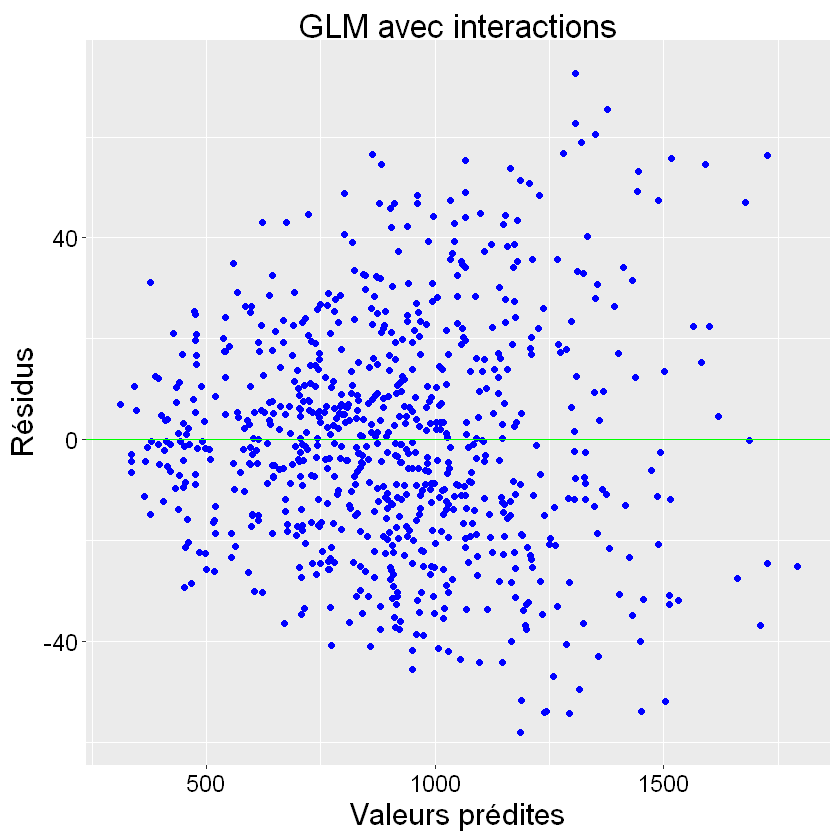

In [ ]:
### glm on calories burned with interaction terms ###

# Fit the model with interaction terms

modele_interactions <- glm(Calories_Burned ~ (.)^2, data = gym_train, family = gaussian)
summary(modele_interactions)

# Résidus
residus_glm <- resid(modele_interactions)

# Valeurs ajustées (prédictions du modèle sur l'échantillon d'entraînement)
fitted_glm <- fitted(modele_interactions)

# Visualisation des résidus
gplot.res(fitted_glm, residus_glm, "GLM avec interactions")



Call:
glm(formula = Calories_Burned ~ (.)^2, family = gaussian, data = gym_train)

Coefficients: (8 not defined because of singularities)
                                                          Estimate Std. Error
(Intercept)                                             -1.159e+03  7.420e+02
Age                                                      4.246e+00  2.823e+00
GenderMale                                              -2.893e+02  1.501e+02
LWeight                                                  1.017e+02  1.286e+02
Height..m.                                               2.189e+02  2.820e+02
Max_BPM                                                  4.768e+00  2.611e+00
Avg_BPM                                                  2.921e+00  2.143e+00
Resting_BPM                                             -1.182e+00  4.447e+00
Session_Duration..hours.                                 2.163e+02  1.598e+02
Workout_TypeHIIT                                         2.271e+01  1.010e+02
Wor

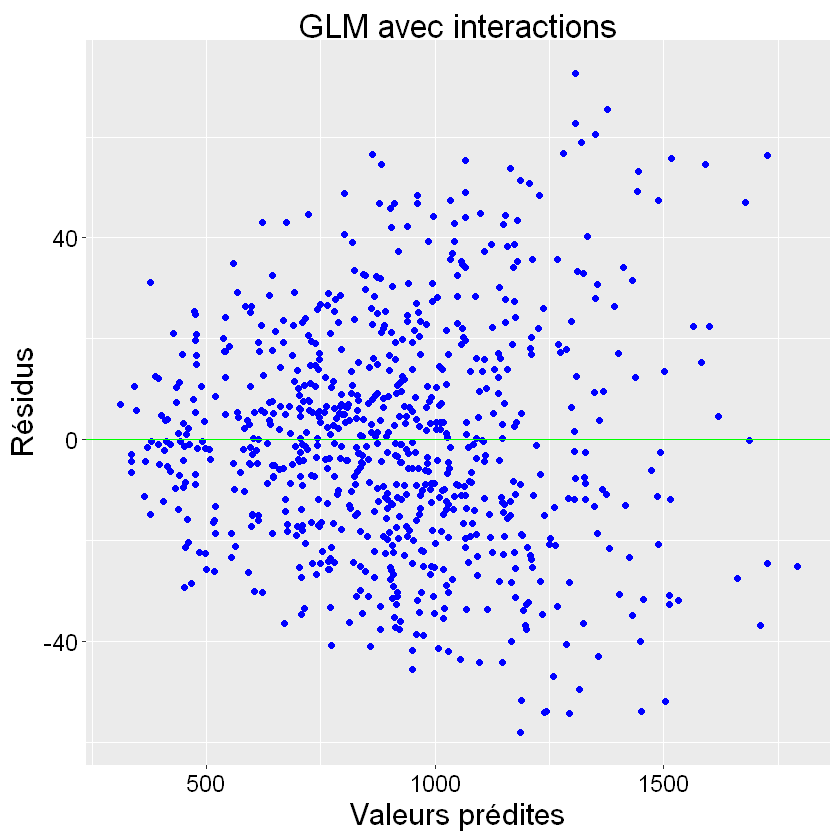

In [16]:
### glm on calories burned with interaction terms ###

# Fit the model with interaction terms

modele_interactions <- glm(Calories_Burned ~ (.)^2, data = gym_train, family = gaussian)
summary(modele_interactions)

# Résidus
residus_glm <- resid(modele_interactions)

# Valeurs ajustées (prédictions du modèle sur l'échantillon d'entraînement)
fitted_glm <- fitted(modele_interactions)

# Visualisation des résidus
gplot.res(fitted_glm, residus_glm, "GLM avec interactions")


In [17]:
# MSE sur le training set
mse_train_glm <- mean(residus_glm^2)

# MSE sur le test set
pred_test_glm <- predict(modele_interactions, newdata = gym_test)
mse_test_glm <- mean((pred_test_glm - gym_test$Calories_Burned)^2)

# Affichage
cat("MSE sur le training set :", mse_train_glm, "\n")
cat("MSE sur le test set :", mse_test_glm, "\n")

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


MSE sur le training set : 505.63 
MSE sur le test set : 715.494 


On remarque déjà que le MSE de l'échantillon test est plus élevé que celui de l'échantillon d'entrainement. Donc le surapprentissage est évident : Le modèle performe bien sur les données vues, mais généralise mal sur de nouvelles données => Erreur de généralisation.

- En ce qui est du graphe des résidus, on observe une dispersion asymétrique avec des résidus extrêmes (-40 à +40). Cela indique que le modèle ne capture pas correctement certaines relations dans les données, surtout pour les valeurs élevées de calories brûlées. 
- De plus, Le modèle inclut toutes les interactions d'ordre 2 (avec 19 variables initiales → 171 interactions), toutefois on ne retire que 15 interactions significatives.
- Surapprentissage évident :
AIC = 7376.6 (très élevé → pénalise la complexité).
Dispersion résiduelle = 633.26 (variance élevée des résidus).
→ Le modèle capture du bruit plutôt que des signaux réels.

Pour conclure, nous pouvons déduire que le modèle GLM avec interactions n'est pas meilleur que le modèle linéaire simple pour des raisons de complexité, de surapprentissage, et de difficulté d'interprétabilité. C'est pourquoi, nous allons priviligier une approche plus parcimonieuse pour garder un équilibre entre performance et interprétabilité notamment via des techniques de sélection de variables


### LASSO

,Age,GenderFemale,GenderMale,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_TypeHIIT,Workout_TypeStrength,Workout_TypeYoga,SFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.3,Workout_Frequency..days.week.4,Workout_Frequency..days.week.5,Experience_Level2,Experience_Level3
2,0.58677041,1,0,0.19779559,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,1,0,0,-1.7625553,-0.8567881,0,1,0,1,0
3,-0.55678178,1,0,-0.14540416,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,0,0,0,-1.5948489,-0.5262097,0,1,0,1,0
5,-0.06668799,0,1,-1.55230634,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,0,1,0,-0.5728511,0.3002366,1,0,0,0,0
6,1.40359340,1,0,-0.72427809,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,1,0,0,1.3988024,0.1349473,0,0,1,0,1
7,-0.23005259,0,1,-0.03075534,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,0,0,0,0.6865113,-0.5262097,1,0,0,1,0
8,0.09667661,1,0,-0.06166344,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,0,0,0,-0.8643778,-1.1873666,1,0,0,1,0


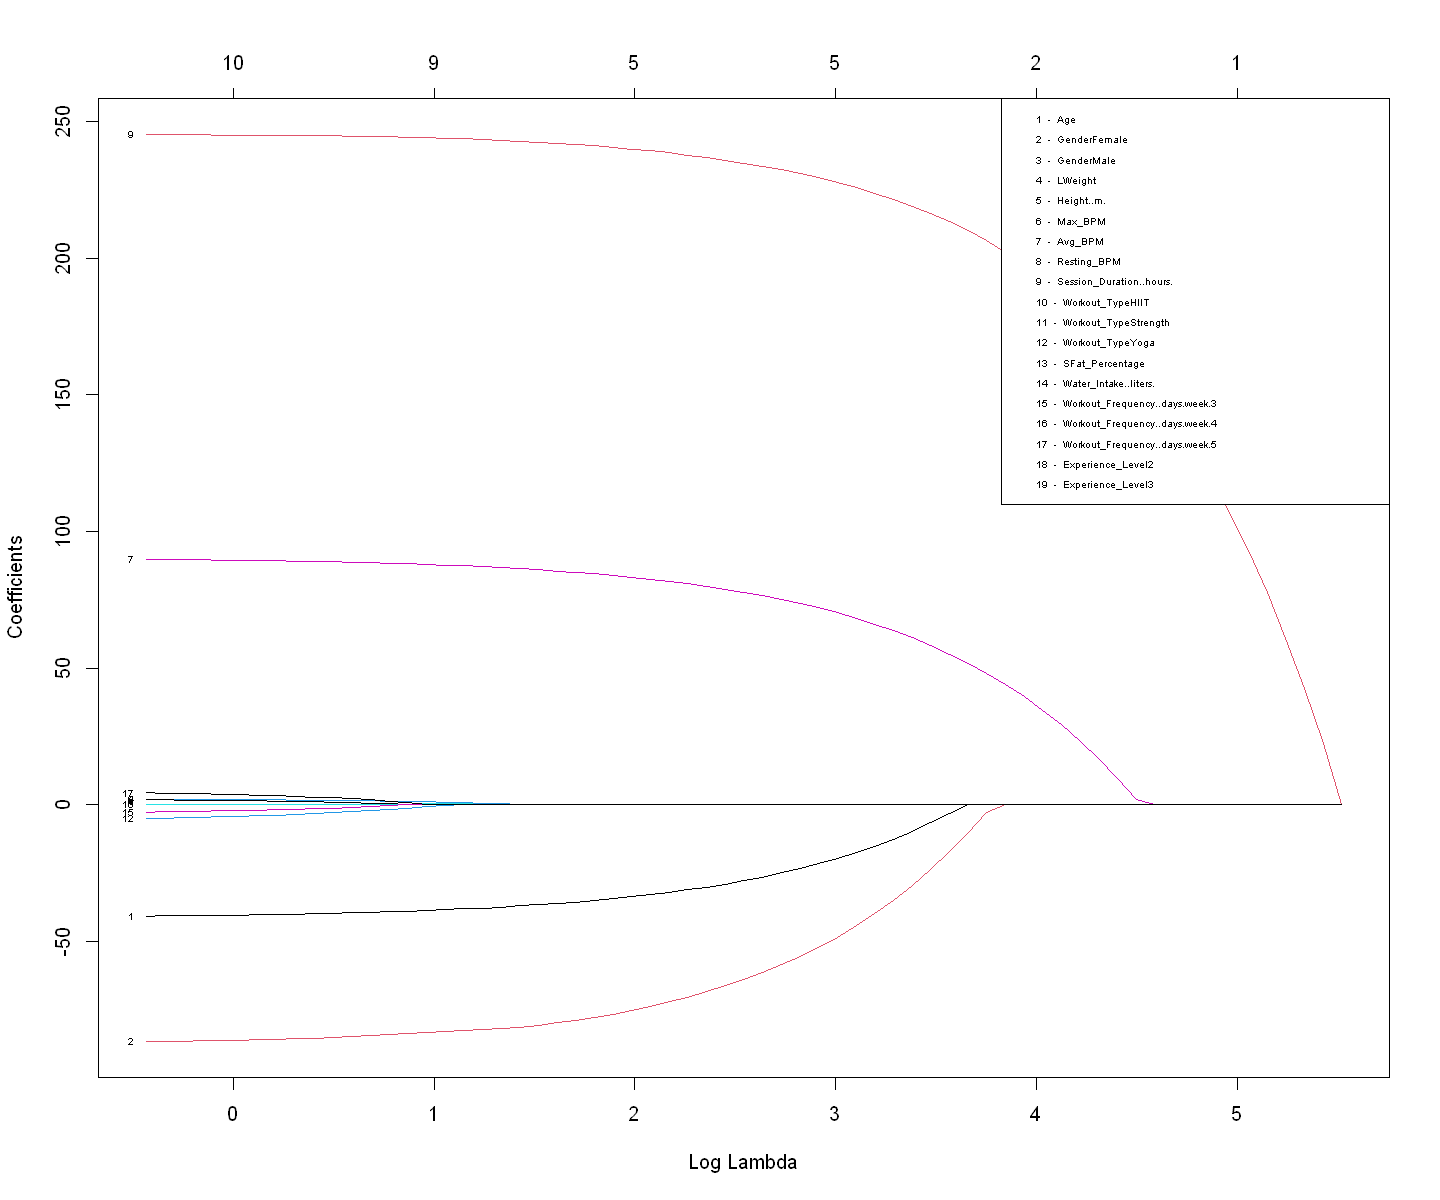

In [41]:

x.mat <- model.matrix(Calories_Burned ~ . -1, data = gym_train_scaled)
y.vec <- gym_train_scaled$Calories_Burned


head(x.mat)

# Fit the lasso model
reg.lasso <- glmnet(x.mat, y.vec, alpha = 1, nfolds = 10) # alpha = 1 for lasso

# Plot the coefficients
options(repr.plot.width=12, repr.plot.height=10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)), cex = 0.5)





- Nous pouvons observer  l'évolution des coefficients des variables en fonction de la pénalisation λ. En effet, plus lambda est petit, moins il n'ya de pénalisation. Ce qui explique les nombreux coefficients non nuls. Parallèlement, pour des lambdas grands, il y'a une forte pénalisation et on donne beaucoup d'importance à la parcimonie face à la complexité du modèle, ce qui pousse de nombreux coefficients à devenir nuls. Cela permet de sélectionner uniquement les variables les plus pertinentes, réduisant ainsi le surapprentissage et améliorant la capacité de généralisation du modèle. 


Comment choisir la valeur optimale de λ qui équilibre au mieux la simplicité du modèle et sa capacité à généraliser ?

C'est ici qu'intervient la validation croisée.  Alors que le premier graphique nous montrait quelles variables sont importantes, la validation croisée nous dira combien de variables garder pour éviter le surapprentissage. Cette étape est essentielle pour transformer notre exploration théorique en un modèle opérationnel et robuste.


Call:  cv.glmnet(x = x.mat, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.711    64    1687 60.30      12
1se  3.797    46    1740 76.81       7

Best lambda:  0.71141 	 	MSE for best lambda:  1687.447 
Best lambda 1se:  3.79661 	MSE for best lambda 1se:  1687.447 


20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                     9.488110e+02
Age                            -3.747170e+01
GenderFemale                   -8.187953e+01
GenderMale                      1.228099e-11
LWeight                         3.814220e-01
Height..m.                      .           
Max_BPM                         .           
Avg_BPM                         8.673607e+01
Resting_BPM                     .           
Session_Duration..hours.        2.431442e+02
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga                .           
SFat_Percentage                 1.927115e-01
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5  .           
Experience_Level2               .           
Experience_Level3               .           

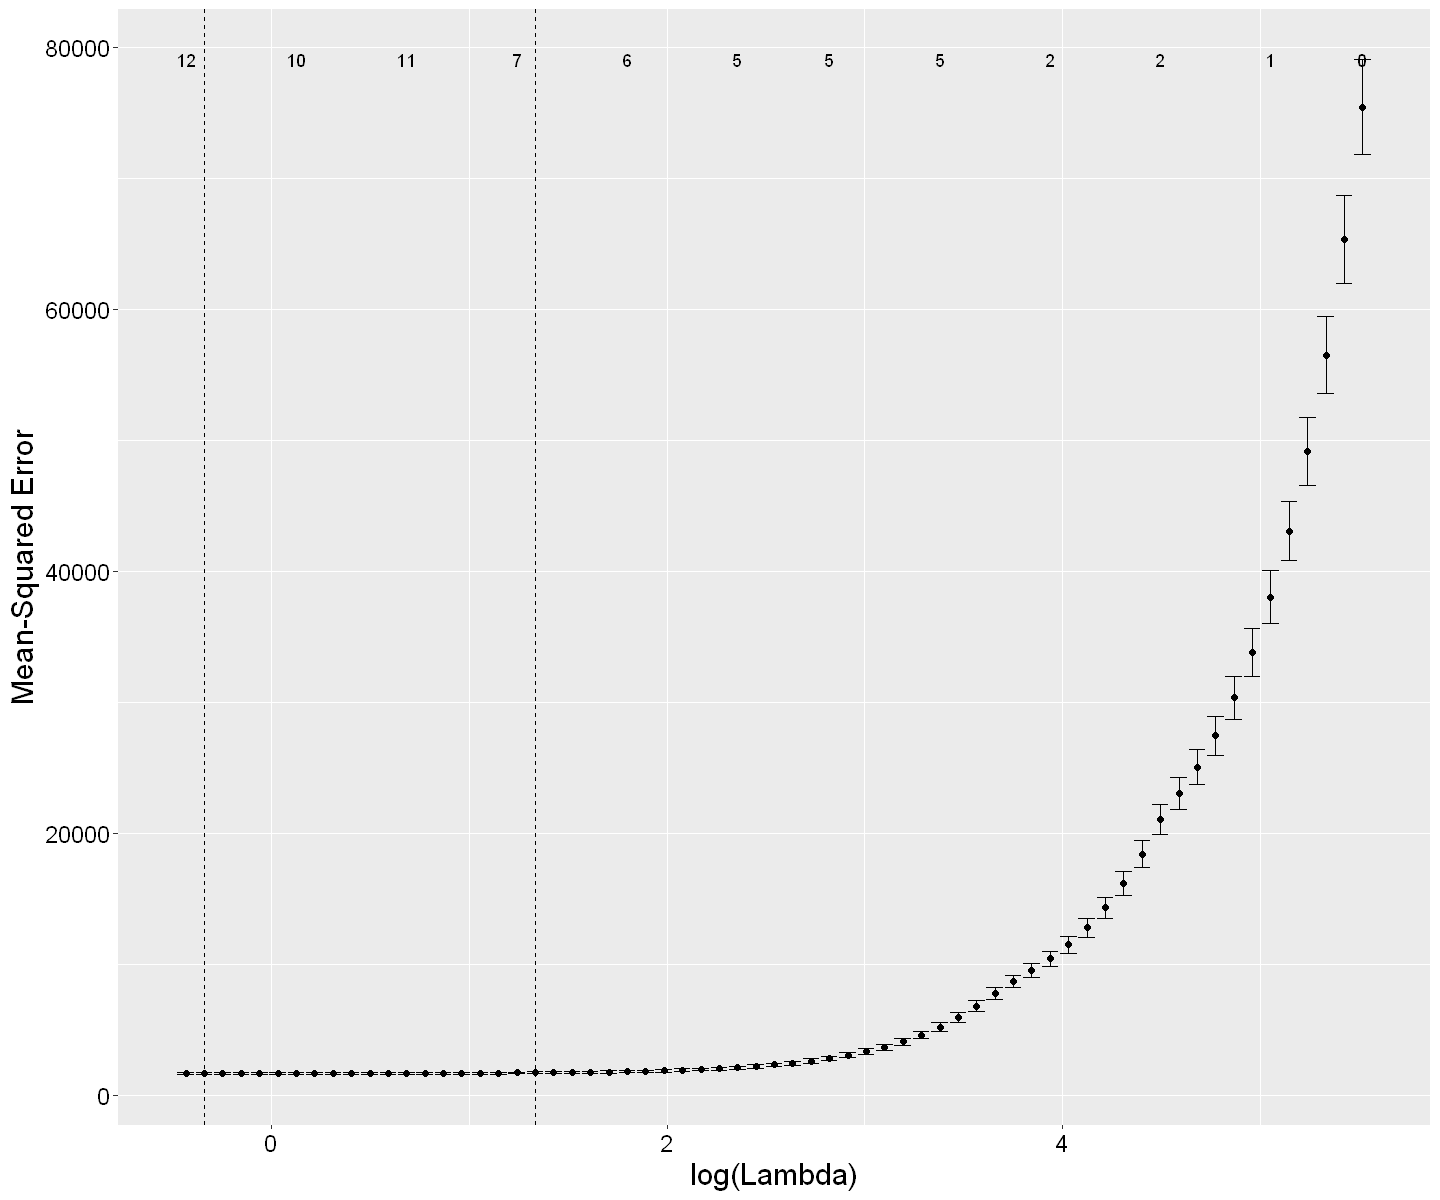

In [24]:
# Cross-validation
reg.lasso.cv <- cv.glmnet(x.mat, y.vec, alpha = 1, nfolds = 10)
reg.lasso.cv
autoplot(reg.lasso.cv)

cat("Best lambda: ", round(reg.lasso.cv$lambda.min,5), "\t \t")
cat("MSE for best lambda: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")
cat("Best lambda 1se: ", round(reg.lasso.cv$lambda.1se,5), "\t")
cat("MSE for best lambda 1se: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")


# Extract the best model
coef(reg.lasso.cv, s = "lambda.1se")
     

Nous avons donc 
lambda.min (0.711) : Lambda optimal minimisant le MSE (1687.45).

lambda.1se (3.796) : Lambda plus grand, conservant un MSE dans l'intervalle *"min + 1 erreur standard"*.
→ Le Modèle le plus simple (7 variables vs 12 pour lambda.min), idéal pour la généralisation.

D'après le graphique, nous visualisons l'évolution de l’erreur quadratique moyenne (MSE) évolue lorsque l’on change la pénalisation λ et nous remarquons :
- Pour des petits lambdas, la pénalisation est faible et donc le MSE est plus élevé car le modèle est plus complexe (possible surapprentissage)
- Au niveau de λ_min (le point le plus bas du nuage), nous avons une erreur minimale et nous gardons en général un nombre modéré de variables (ici autour de 7).
- Au niveau de  λ_1se: On choisit un λ un peu plus grand → on réduit davantage le nombre de variables (ici ~6), tout en restant dans l’intervalle d’erreur de la MSE minimale (modèle plus simple sans perte significative de performance).
- Pour de grands lambdas, la pénalisation est forte donc presque tous les coefficients passent à zéro et MSE remonte (modèle trop parcimonieux).

C'est justement ce que nous observons dans le graphe suivant où les coefficients s'annullent au fur et à mesure que lambda augmente


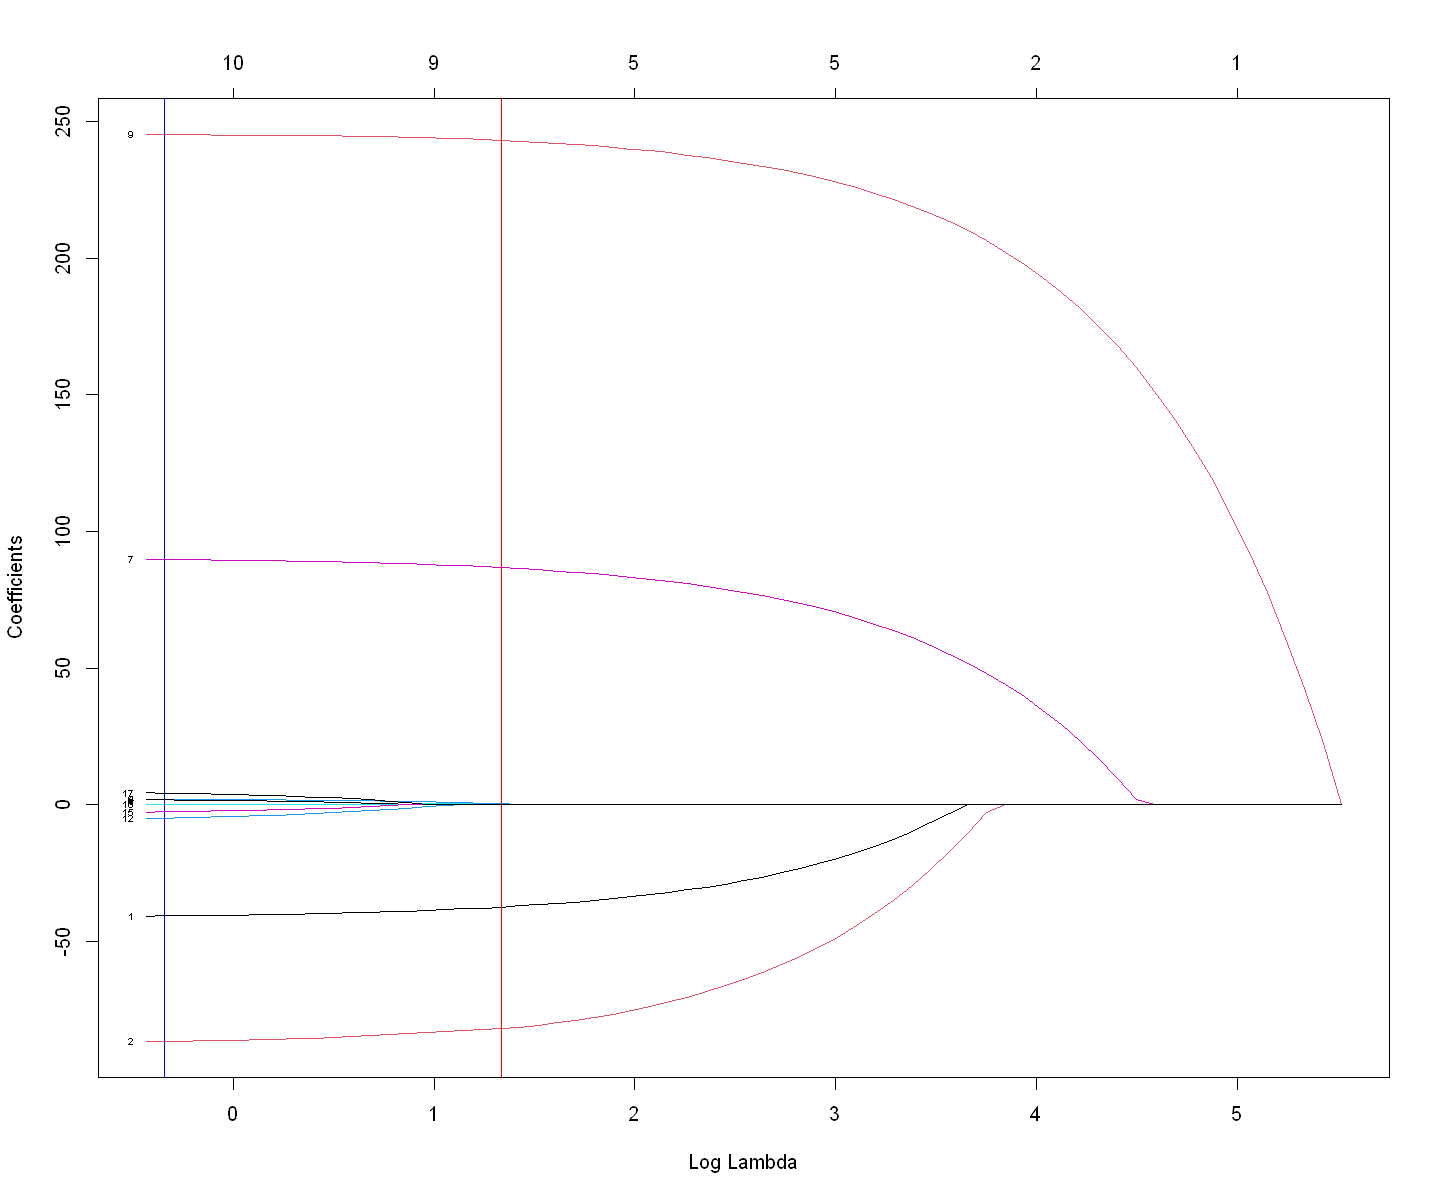

In [25]:

plot(reg.lasso, xvar = "lambda", label = TRUE)
abline(v=log(reg.lasso.cv$lambda.1se),col="red")
abline(v=log(reg.lasso.cv$lambda.min),col="blue")

[1] 0.9785284

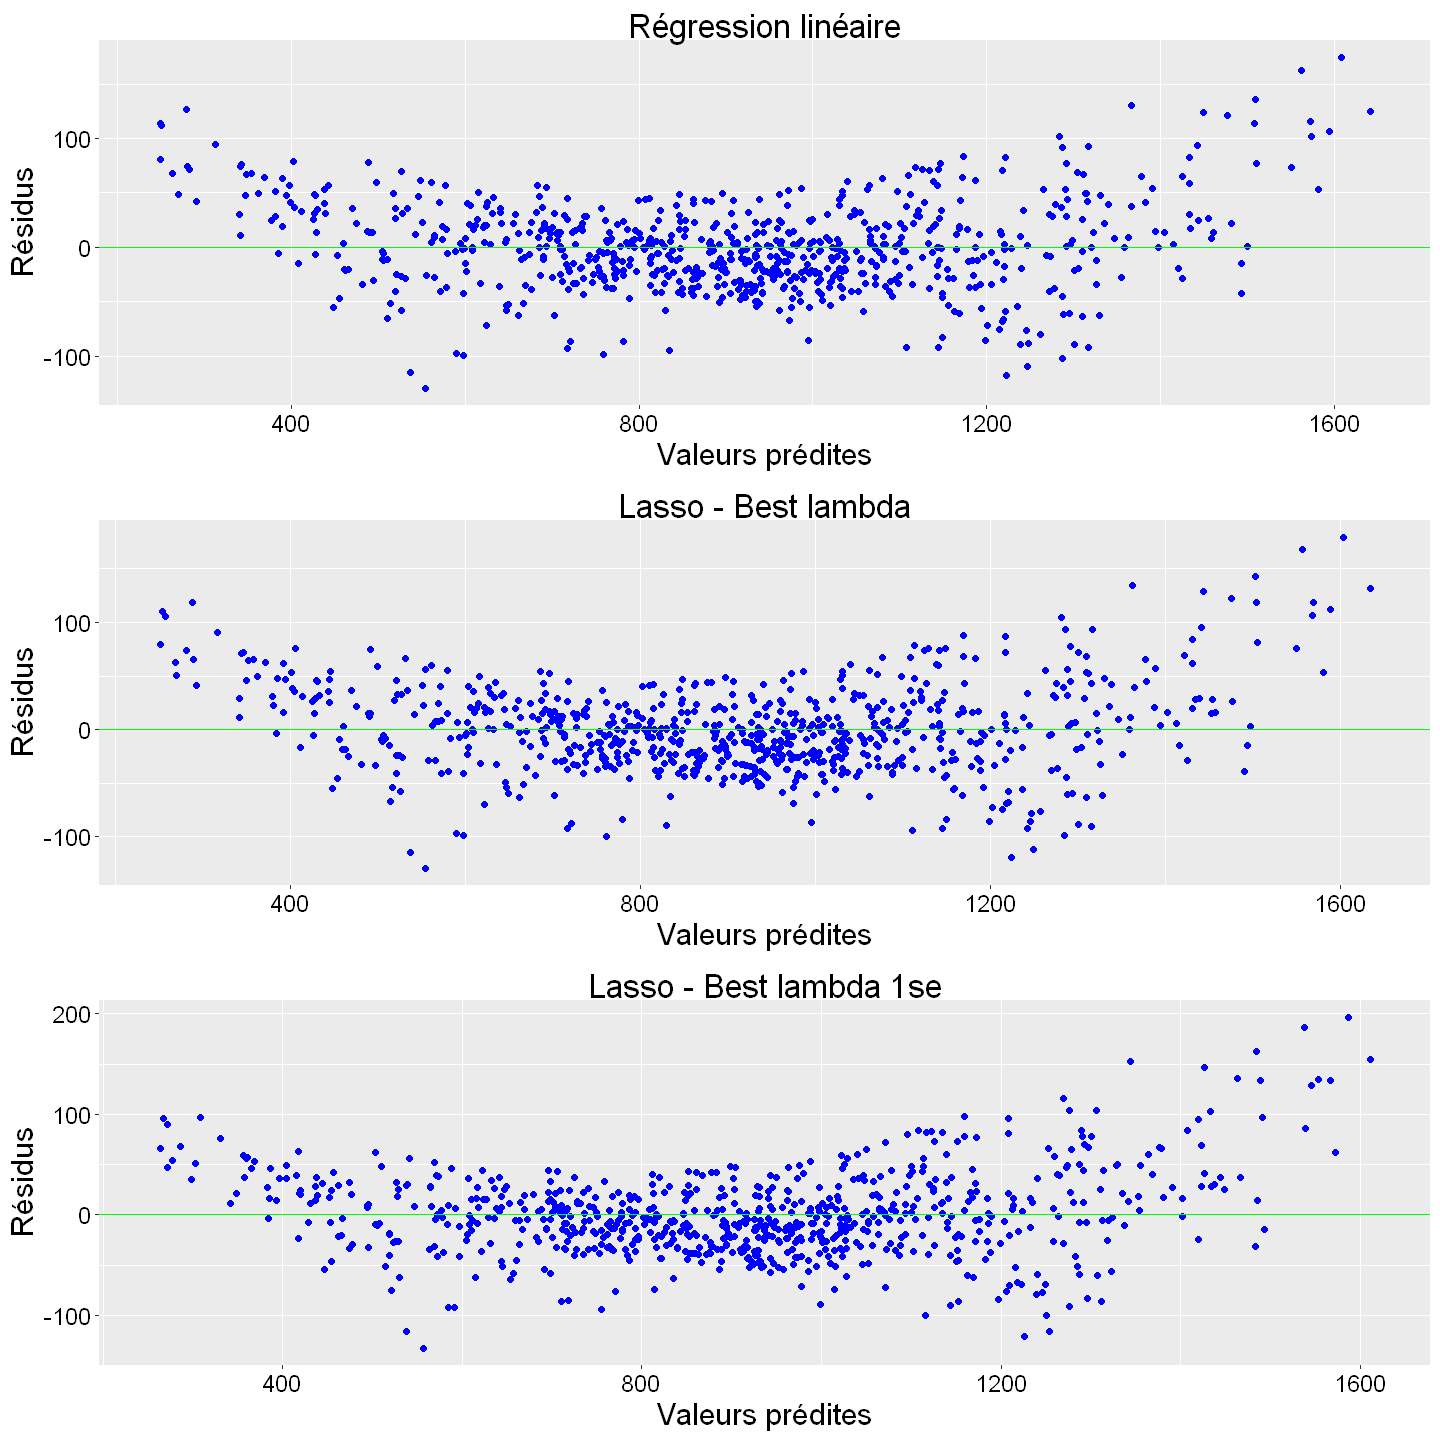

In [27]:
# Extract fitted values and residuals
fit.lasso.min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso.min <- y.vec - fit.lasso.min

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- y.vec - fit.lasso.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.min, res.lasso.min, "Lasso - Best lambda")
p2 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)



In [28]:
# 1. Valeurs et résidus déjà calculés
y_train <- y.vec
fit_min  <- fit.lasso.min
fit_1se  <- fit.lasso.1se

# 2. Somme des carrés totaux (SST)
sst <- sum( (y_train - mean(y_train))^2 )

# 3. Somme des carrés des résidus (SSE) pour chaque modèle
sse_lasso_min <- sum( (y_train - fit_min)^2 )
sse_lasso_1se <- sum( (y_train - fit_1se)^2 )

# 4. Calcul des R2
r2_lm        <- summary(reg.lm)$r.squared
r2_lasso_min <- 1 - sse_lasso_min / sst
r2_lasso_1se <- 1 - sse_lasso_1se / sst

# 5. Affichage
cat("R2 (LM)           :", round(r2_lm,  3), "\n")
cat("R2 (Lasso λ_min)  :", round(r2_lasso_min, 3), "\n")
cat("R2 (Lasso λ_1se)  :", round(r2_lasso_1se, 3), "\n")


R2 (LM)           : 0.979 
R2 (Lasso λ_min)  : 0.978 
R2 (Lasso λ_1se)  : 0.977 


Les trois modèles affichent d’excellentes performances (R² ≃ 0,97). Le Lasso avec λ 1se présente un R² légèrement inférieur, ce qui est attendu puisqu’il écarte davantage de variables.

### Analyse des résidus

Régression linéaire : les résidus sont bien centrés autour de zéro, mais leur dispersion apparaît légèrement hétérogène.

Lasso (λ_min et λ_1se) : les nuages de points restent comparables à ceux de la régression linéaire, avec toutefois une variabilité un peu plus marquée pour λ_1se (voir l’extension de l’axe vertical).

Cette similarité visuelle confirme que les trois modèles offrent des performances prédictives très proches.

### Importance des variables

Session_Duration domine l’explication des calories brûlées (coefficient élevé dans tous les modèles).

Les autres variables n’ont qu’un impact marginal : leur suppression par le Lasso n’altère pas significativement la qualité des prédictions.

 Choix du modèle
Le choix final dépend de la priorité donnée à la complexité ou à la parcimonie. Ici, comme le R² diminue très peu en passant au Lasso λ_1se, ce modèle plus simple est à privilégier.





### Modèle Lasso quadratique : 

In [43]:
# Quadratic model with lasso
x.mat.quad <- model.matrix(Calories_Burned ~ .^2 -1, data = gym_train_scaled)
reg.lasso.quad.cv <- cv.glmnet(x.mat.quad, y.vec, alpha = 1, nfolds = 10)
reg.lasso.quad.cv 
head(x.mat.quad)
R2_lasso_quadratic <- 1 - sum((y.vec - predict(reg.lasso.quad.cv, s = "lambda.min", newx = x.mat.quad))^2) / sum((y.vec - mean(y.vec))^2)
cat("R2 (Lasso Quadratic λ_min)  :", round(R2_lasso_quadratic, 3), "\n")
# coef(reg.lasso.quad.cv, s = "lambda.1se")


Call:  cv.glmnet(x = x.mat.quad, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.7114    64   689.9 40.15      53
1se 2.6169    50   729.8 47.99      21

,Age,GenderFemale,GenderMale,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_TypeHIIT,⋯,Water_Intake..liters.:Workout_Frequency..days.week.4,Water_Intake..liters.:Workout_Frequency..days.week.5,Water_Intake..liters.:Experience_Level2,Water_Intake..liters.:Experience_Level3,Workout_Frequency..days.week.3:Experience_Level2,Workout_Frequency..days.week.4:Experience_Level2,Workout_Frequency..days.week.5:Experience_Level2,Workout_Frequency..days.week.3:Experience_Level3,Workout_Frequency..days.week.4:Experience_Level3,Workout_Frequency..days.week.5:Experience_Level3
2,0.58677041,1,0,0.19779559,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,1,⋯,-0.8567881,0.0000000,-0.8567881,0.0000000,0,1,0,0,0,0
3,-0.55678178,1,0,-0.14540416,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,0,⋯,-0.5262097,0.0000000,-0.5262097,0.0000000,0,1,0,0,0,0
5,-0.06668799,0,1,-1.55230634,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,0,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0,0,0,0,0,0
6,1.40359340,1,0,-0.72427809,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,1,⋯,0.0000000,0.1349473,0.0000000,0.1349473,0,0,0,0,0,1
7,-0.23005259,0,1,-0.03075534,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,0,⋯,0.0000000,0.0000000,-0.5262097,0.0000000,1,0,0,0,0,0
8,0.09667661,1,0,-0.06166344,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,0,⋯,0.0000000,0.0000000,-1.1873666,0.0000000,1,0,0,0,0,0


R2 (Lasso Quadratic λ_min)  : 0.992 


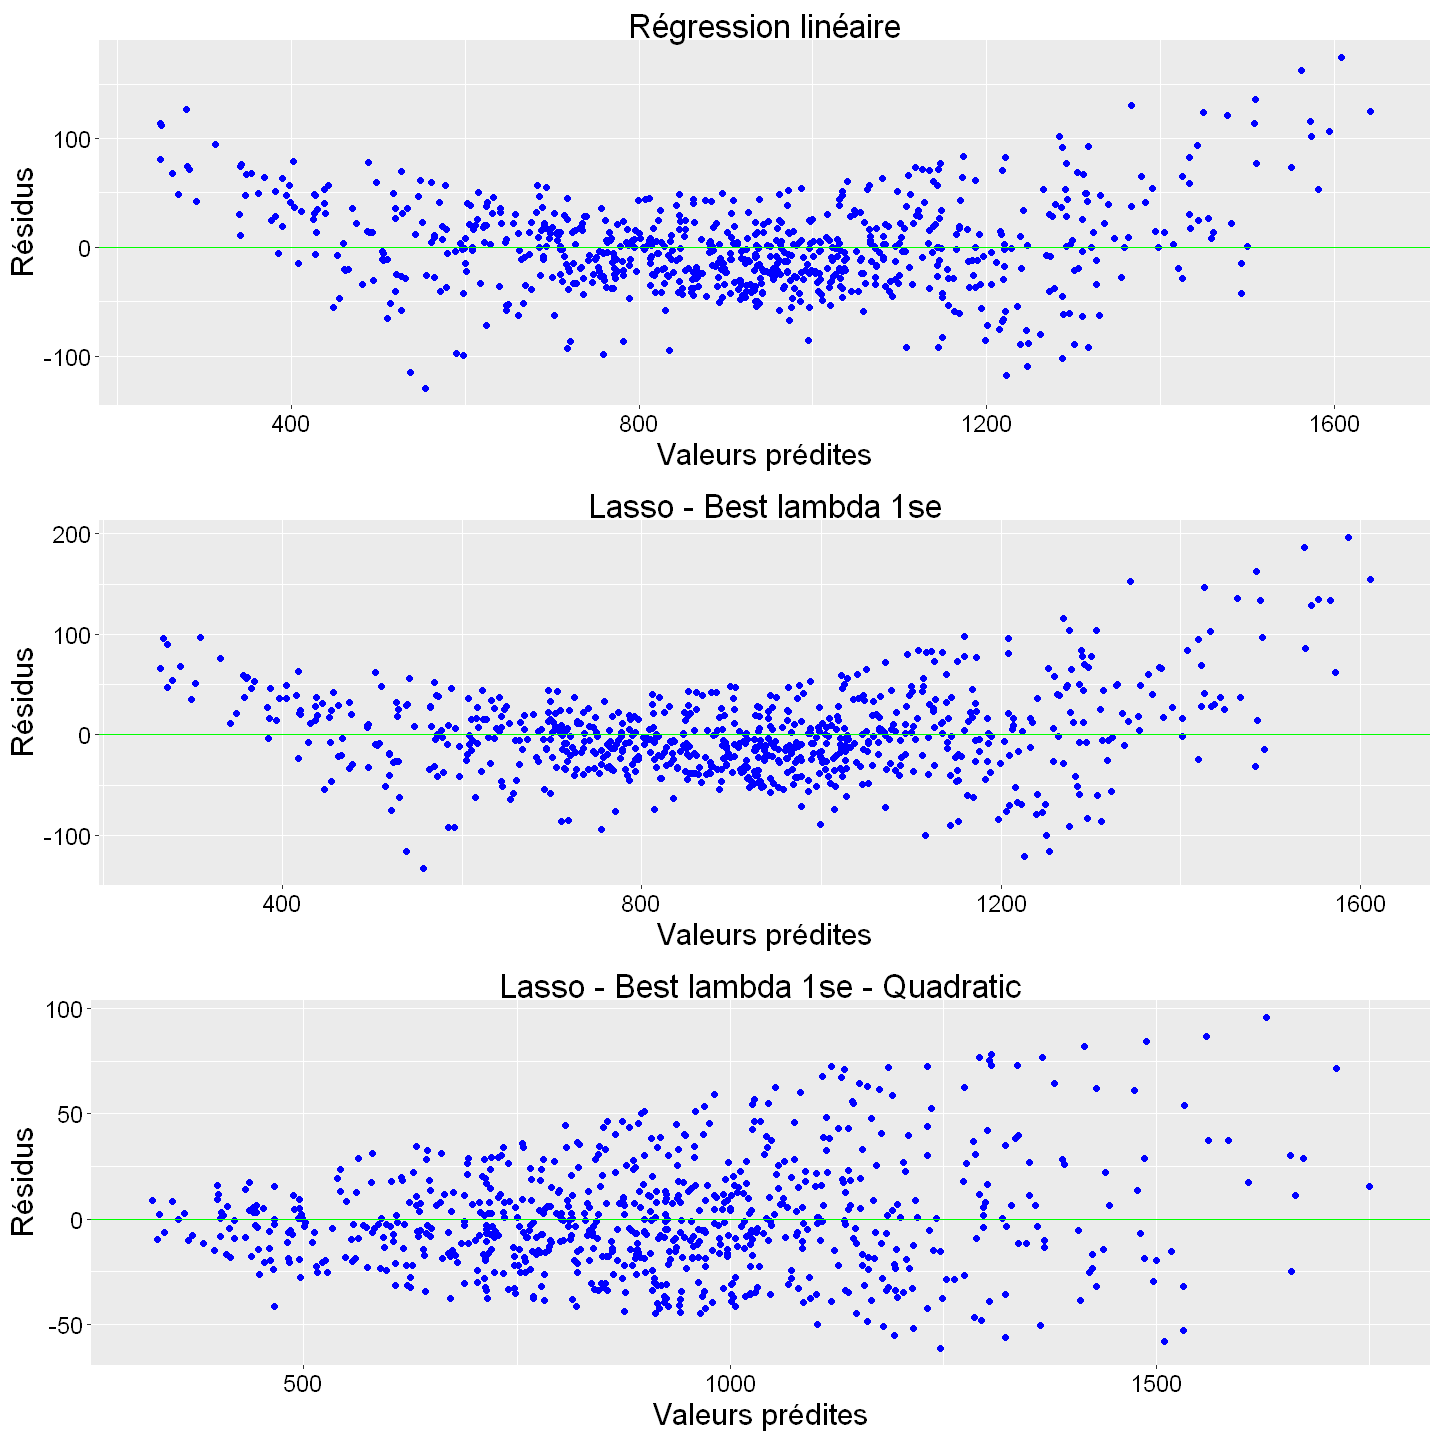

In [44]:
fit.lasso.quad.1se <- predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad)
res.lasso.quad.1se <- y.vec - fit.lasso.quad.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")
p2 <- gplot.res(fit.lasso.quad.1se, res.lasso.quad.1se, "Lasso - Best lambda 1se - Quadratic")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

#### Interpretations :

- Le lasso quadratique présente de très bons résultats avec un R^2 = 0.992 et MSE = 570.61, indiquant une capacité à expliquer la variance des calories brûlées grâce aux interactions non linéaires. Les modèles linéaires (Régression, Lasso) ont des performances très similaires (R² ~0.977-0.979), mais inférieures.

- En ce qui concerne la complexité du modèle, nous remarquons qu'il capture des interactions complexes (ex. Session_Duration:Avg_BPM) et retient 21 variables avec lambda.1se, contre 53 avec lambda.min. Ce qui permet de garder un bon compromis performance-complexité.

- D'après le graphe des résidus, nous remarquons qu'ils sont mieux contrôlés (dispersion réduite) => Meilleure adéquation aux données.

Nous pouvons résumer tout ceci dans le tableau suivant:

| Modèle                        | R² (Test) | MSE (Test) | Variables Non Nulles         | Complexité                   | Généralisation               |
|-------------------------------|-----------|------------|------------------------------|------------------------------|------------------------------|
| **Régression Linéaire**       | 0.979     | ~1 661     | 18 (toutes conservées)       | Très élevée                  | Risque de surapprentissage   |
| **Lasso (λ_min)**             | 0.978     | ~1 638     | 12                           | Moyenne                      | Bon compromis                |
| **Lasso (λ_1se)**             | 0.977     | ~1 740     | 7                            | Faible                       | Haute robustesse             |
| **Lasso Quadratique**         | 0.992     | 570.61     | 21 (λ_1se) / 53 (λ_min)      | Très élevée (interactions)   | Très performant, mais plus complexe |


Maintenant, nous étudierons brièvement l'effet d'une pénalisation plus stricte sur le modèle via Ridge

### Ridge

MSE Ridge (lambda.min)  : 2417.686 
MSE Ridge (lambda.1se)  : 2417.686 
R² Ridge (λ_min)  : 0.968 
R² Ridge (λ_1se)  : 0.968 


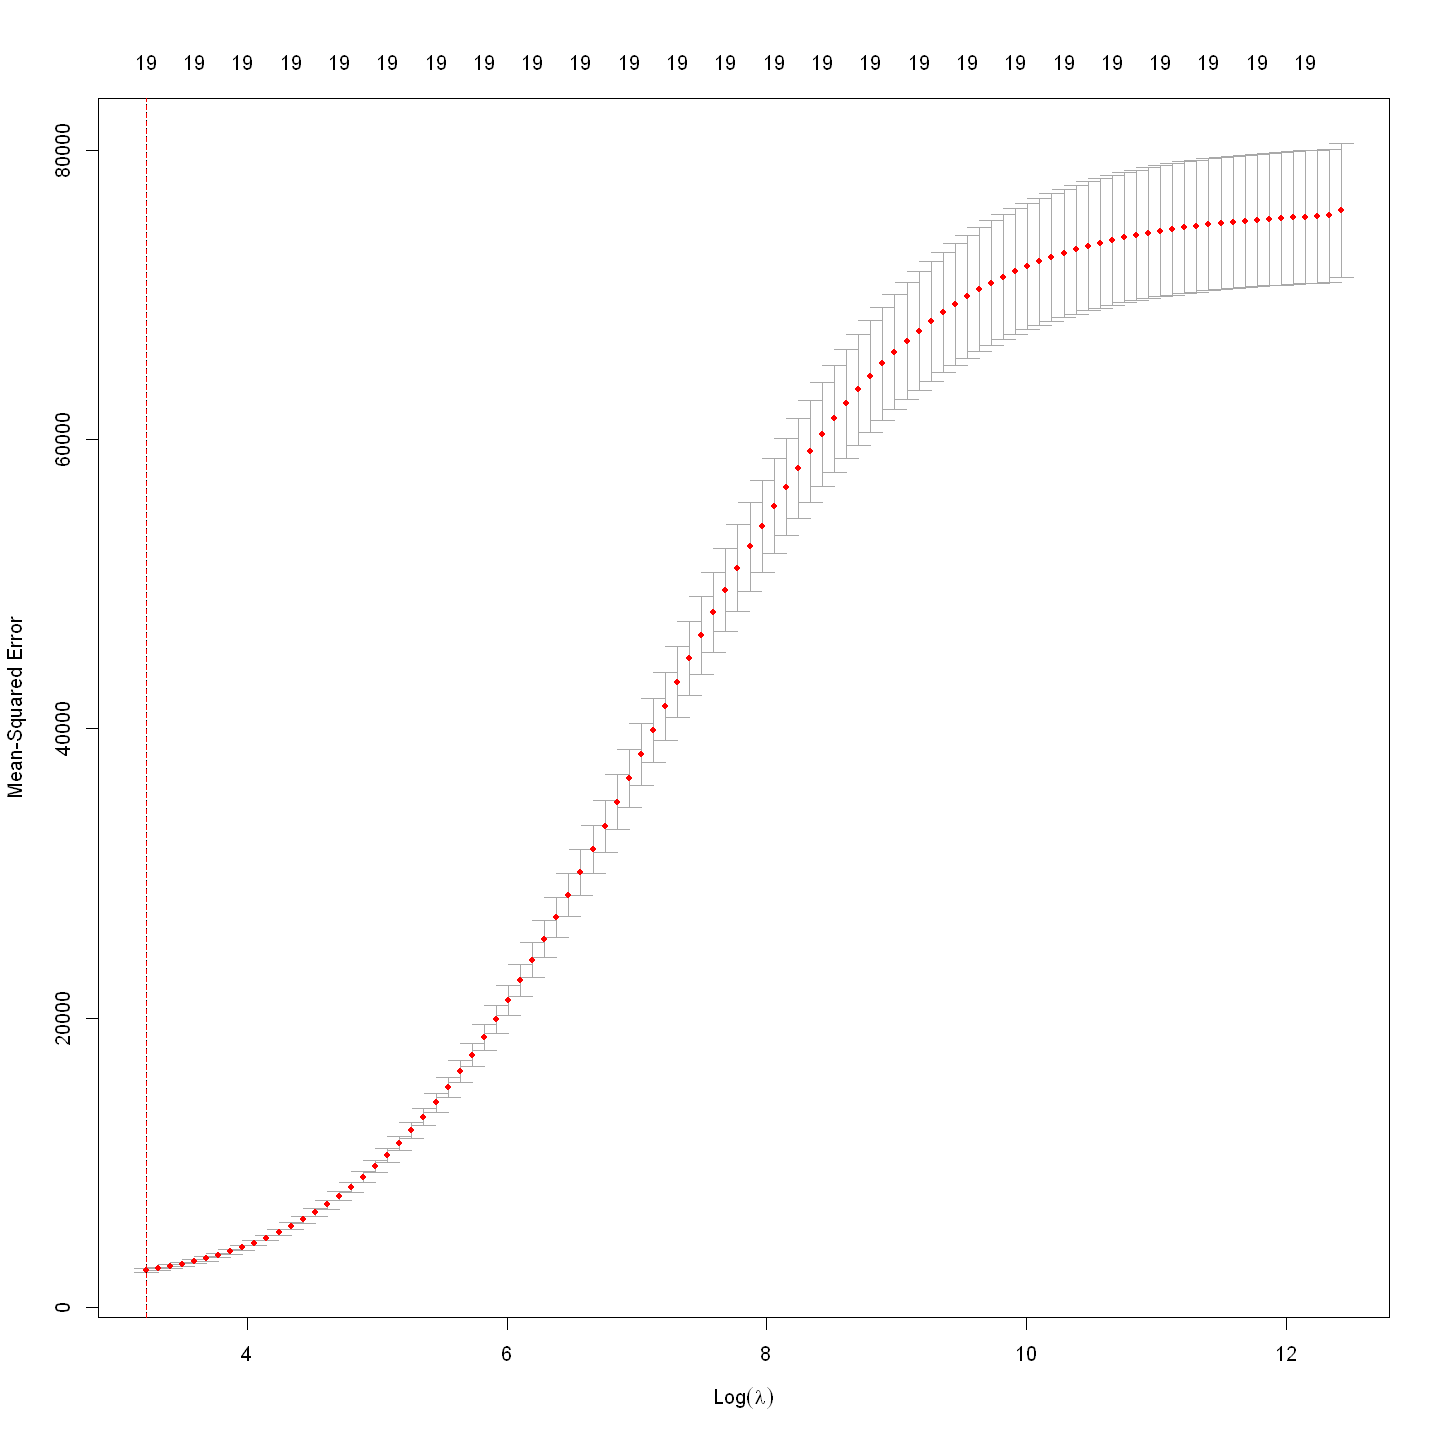

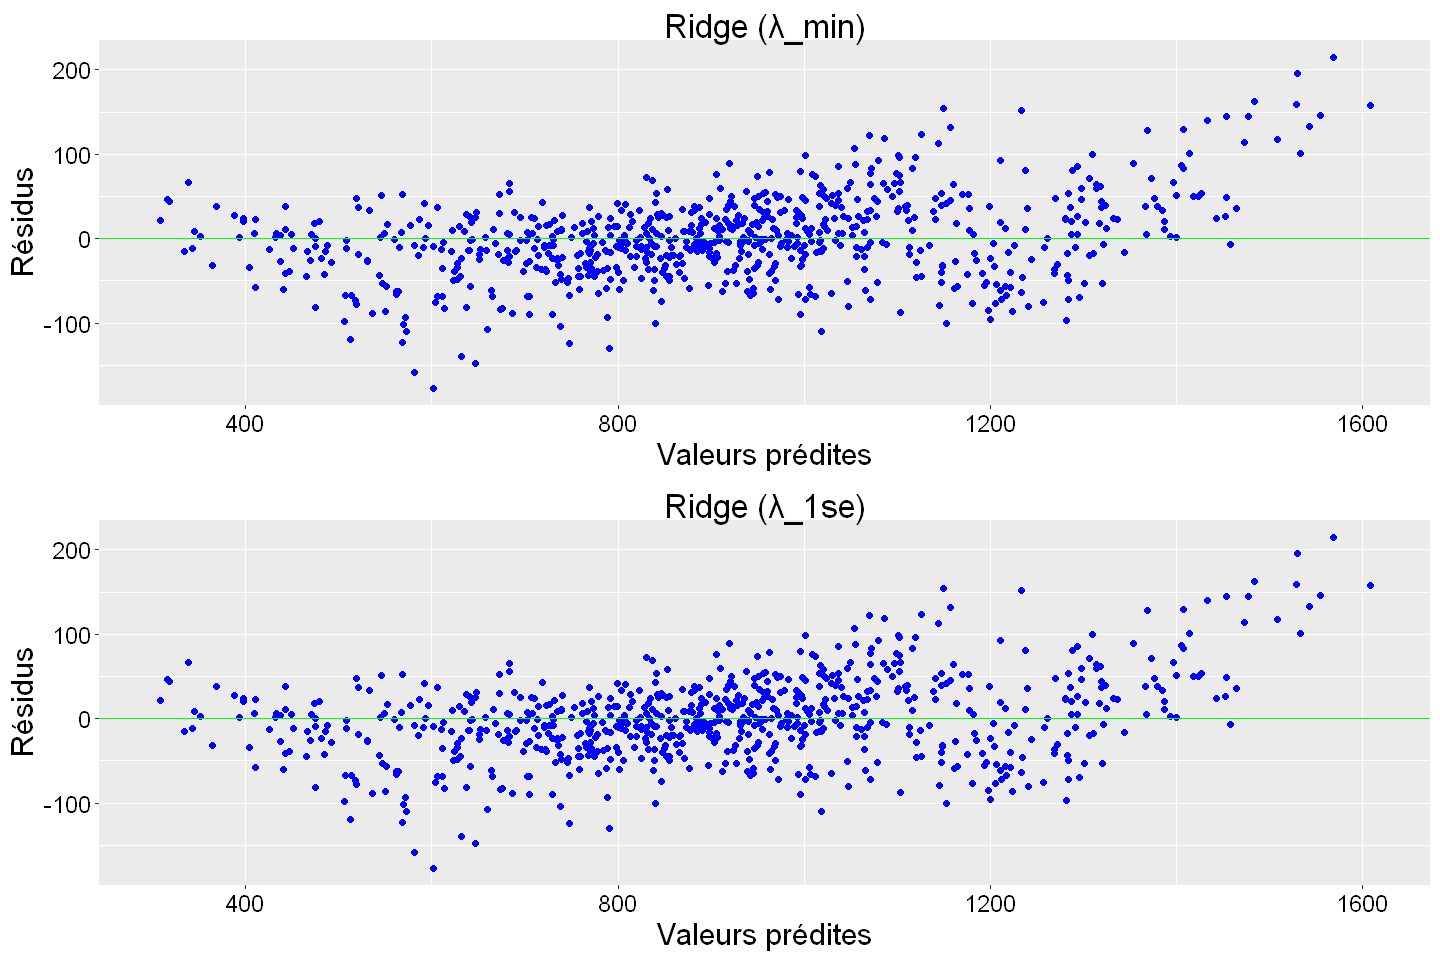

In [38]:
# 1. Construction de la matrice de design et du vecteur cible (déjà faits) :
#    x.mat <- model.matrix(Calories_Burned ~ . -1, data = gym_train_scaled)
#    y.vec <- gym_train_scaled$Calories_Burned

# 2. Validation croisée pour choisir lambda en Ridge (alpha = 0)
library(glmnet)
set.seed(1234)
cv.ridge <- cv.glmnet(x.mat, y.vec, 
                      alpha = 0,        # alpha = 0 pour Ridge 
                      nfolds = 10)      # 10-fold CV

# 3. Tracé de la CV MSE en fonction de log(lambda)
plot(cv.ridge)
abline(v = log(cv.ridge$lambda.min), col = "blue", lty = 2)
abline(v = log(cv.ridge$lambda.1se), col = "red",  lty = 2)

# 4. Extraction des coefficients au meilleur lambda
coef_min  <- coef(cv.ridge, s = "lambda.min")
coef_1se  <- coef(cv.ridge, s = "lambda.1se")

# 5. Prédictions et résidus sur l’échantillon d’entraînement
fit_ridge_min <- predict(cv.ridge, s = "lambda.min", newx = x.mat)
res_ridge_min <- y.vec - as.numeric(fit_ridge_min)

fit_ridge_1se <- predict(cv.ridge, s = "lambda.1se", newx = x.mat)
res_ridge_1se <- y.vec - as.numeric(fit_ridge_1se)

# 6. Calcul des MSE
mse_ridge_train_min  <- mean(res_ridge_min^2)
mse_ridge_train_1se  <- mean(res_ridge_1se^2)

cat("MSE Ridge (lambda.min)  :", round(mse_ridge_train_min,  3), "\n")
cat("MSE Ridge (lambda.1se)  :", round(mse_ridge_train_1se,  3), "\n")

# 7. (Optionnel) Comparaison des R² in-sample
sst <- sum((y.vec - mean(y.vec))^2)
r2_ridge_min <- 1 - sum(res_ridge_min^2) / sst
r2_ridge_1se <- 1 - sum(res_ridge_1se^2) / sst

cat("R² Ridge (λ_min)  :", round(r2_ridge_min, 3), "\n")
cat("R² Ridge (λ_1se)  :", round(r2_ridge_1se, 3), "\n")

# 8. Tracé des résidus
options(repr.plot.width=12, repr.plot.height=8)
p_ridge_min <- gplot.res(fit_ridge_min, res_ridge_min, "Ridge (λ_min)")
p_ridge_1se <- gplot.res(fit_ridge_1se, res_ridge_1se, "Ridge (λ_1se)")
grid.arrange(p_ridge_min, p_ridge_1se, ncol = 1)



Nous observons que bien que le R^2 de Ridge soit très élevé, le MSE s'avère très élevé également. Ce qui signifie que l'équilibre biais variance n'est pas bien géré dans ce cas là et que le modèle a tendance à surapprendre.

Après avoir étudié comment la pénalisation du Lasso et de Ridge permet de réduire la complexité du modèle tout en conservant une haute performance prédictive, nous allons désormais nous intéresser à une autre approche de régularisation issue du machine learning : la Support Vector Regression (SVR). Cette méthode, fondée sur la théorie des marges maximales et l’utilisation de noyaux, offre un compromis différent entre biais et variance, et mérite d’être comparée au Lasso pour évaluer sa robustesse et sa capacité à capturer d’éventuelles relations non linéaires dans nos données de calories brûlées.

# SVR

In [29]:
install.packages("e1071")
library(e1071)

Installation du package dans 'C:/Users/essak/AppData/Local/R/win-library/4.3'
(car 'lib' n'est pas spécifié)



le package 'e1071' a été décompressé et les sommes MD5 ont été vérifiées avec succés


Warning message:
"impossible de supprimer l'installation précédente du package 'e1071'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problème lors de la copie de C:\Users\essak\AppData\Local\R\win-library\4.3\00LOCK\e1071\libs\x64\e1071.dll vers C:\Users\essak\AppData\Local\R\win-library\4.3\e1071\libs\x64\e1071.dll: Permission denied"
Warning message:
"'e1071' restauré"



Les packages binaires téléchargés sont dans
	C:\Users\essak\AppData\Local\Temp\RtmpyKHnMn\downloaded_packages


Warning message:
"le package 'e1071' a été compilé avec la version R 4.3.3"


In [68]:
svr_lin <- svm(Calories_Burned ~ ., data = gym_train_scaled, kernel = "linear")
summary(svr_lin)


Call:
svm(formula = Calories_Burned ~ ., data = gym_train_scaled, kernel = "linear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  361






In [69]:
# 1. Prédictions sur l'échantillon d'entraînement
y_train <- gym_train_scaled$Calories_Burned
pred_train <- predict(svr_lin, newdata = gym_train_scaled)

# 2. Calcul du SSE et du SST sur l'entraînement
sse_train <- sum((y_train - pred_train)^2)
sst_train <- sum((y_train - mean(y_train))^2)

# 3. R2 entraînement
R2_train <- 1 - sse_train / sst_train
cat("R2 (train) pour SVR lin :", round(R2_train, 3), "\n")


# 4. Prédictions sur l'échantillon de test
y_test  <- gym_test_scaled$Calories_Burned
pred_test <- predict(svr_lin, newdata = gym_test_scaled)

# 5. Calcul du SSE et du SST sur le test
sse_test <- sum((y_test - pred_test)^2)
sst_test <- sum((y_test - mean(y_test))^2)

# 6. R2 test
R2_test <- 1 - sse_test / sst_test
cat("R2 (test) pour SVR lin  :", round(R2_test, 3), "\n")

mse_train <- mean((y_train - pred_train)^2)
cat("MSE (train) pour SVR lin :", round(mse_train, 3), "\n")

# 2. MSE sur l'échantillon de test
mse_test  <- mean((y_test  - pred_test )^2)
cat("MSE (test)  pour SVR lin :", round(mse_test,  3), "\n")


R2 (train) pour SVR lin : 0.978 
R2 (test) pour SVR lin  : 0.982 
MSE (train) pour SVR lin : 1644.185 
MSE (test)  pour SVR lin : 1200.669 


In [61]:
svr_rbf <- svm(Calories_Burned ~ ., data = gym_train_scaled, kernel = "radial")
summary(svr_rbf)


Call:
svm(formula = Calories_Burned ~ ., data = gym_train_scaled, kernel = "radial")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  317






In [65]:
# 1. Prédictions sur l'échantillon d'entraînement
y_train <- gym_train_scaled$Calories_Burned
pred_train <- predict(svr_rbf, newdata = gym_train_scaled)

# 2. Calcul du SSE et du SST sur l'entraînement
sse_train <- sum((y_train - pred_train)^2)
sst_train <- sum((y_train - mean(y_train))^2)

# 3. R2 entraînement
R2_train <- 1 - sse_train / sst_train
cat("R2 (train) pour SVR rbf :", round(R2_train, 3), "\n")


# 4. Prédictions sur l'échantillon de test
y_test  <- gym_test_scaled$Calories_Burned
pred_test <- predict(svr_rbf, newdata = gym_test_scaled)

# 5. Calcul du SSE et du SST sur le test
sse_test <- sum((y_test - pred_test)^2)
sst_test <- sum((y_test - mean(y_test))^2)

# 6. R2 test
R2_test <- 1 - sse_test / sst_test
cat("R2 (test) pour SVR rbf  :", round(R2_test, 3), "\n")

mse_train <- mean((y_train - pred_train)^2)
cat("MSE (train) pour SVR RBF :", round(mse_train, 3), "\n")

# 2. MSE sur l'échantillon de test
mse_test  <- mean((y_test  - pred_test )^2)
cat("MSE (test)  pour SVR RBF :", round(mse_test,  3), "\n")

R2 (train) pour SVR rbf : 0.99 
R2 (test) pour SVR rbf  : 0.985 
MSE (train) pour SVR RBF : 724.766 
MSE (test)  pour SVR RBF : 995.299 


In [66]:
svr_poly <- svm(Calories_Burned ~ ., data = gym_train_scaled, kernel = "poly")
summary(svr_poly)


Call:
svm(formula = Calories_Burned ~ ., data = gym_train_scaled, kernel = "poly")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  3 
      gamma:  0.05263158 
     coef.0:  0 
    epsilon:  0.1 


Number of Support Vectors:  488






In [67]:
# 1. Prédictions sur l'échantillon d'entraînement
y_train <- gym_train_scaled$Calories_Burned
pred_train <- predict(svr_poly, newdata = gym_train_scaled)

# 2. Calcul du SSE et du SST sur l'entraînement
sse_train <- sum((y_train - pred_train)^2)
sst_train <- sum((y_train - mean(y_train))^2)

# 3. R2 entraînement
R2_train <- 1 - sse_train / sst_train
cat("R2 (train) pour SVR poly :", round(R2_train, 3), "\n")


# 4. Prédictions sur l'échantillon de test
y_test  <- gym_test_scaled$Calories_Burned
pred_test <- predict(svr_poly, newdata = gym_test_scaled)

# 5. Calcul du SSE et du SST sur le test
sse_test <- sum((y_test - pred_test)^2)
sst_test <- sum((y_test - mean(y_test))^2)

# 6. R2 test
R2_test <- 1 - sse_test / sst_test
cat("R2 (test) pour SVR poly  :", round(R2_test, 3), "\n")

mse_train <- mean((y_train - pred_train)^2)
cat("MSE (train) pour SVR poly :", round(mse_train, 3), "\n")

# 2. MSE sur l'échantillon de test
mse_test  <- mean((y_test  - pred_test )^2)
cat("MSE (test)  pour SVR poly :", round(mse_test,  3), "\n")

R2 (train) pour SVR poly : 0.955 
R2 (test) pour SVR poly  : 0.929 
MSE (train) pour SVR poly : 3376.651 
MSE (test)  pour SVR poly : 4870.262 


| Kernel               | R² (Test) | MSE (Test)  |
|----------------------|-----------|-------------|
| **SVR Linéaire**     | 0.982     | 1 200.67    |
| **SVR RBF**          | 0.985     | 995.30      |
| **SVR Polynomial**   | 0.929     | 4 870.26    |

Donc, au vu des performances observées, le noyau RBF (radial) est clairement à privilégier pour la SVR


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
       gamma cost
 0.003162278  100

- best performance: 736.6353 


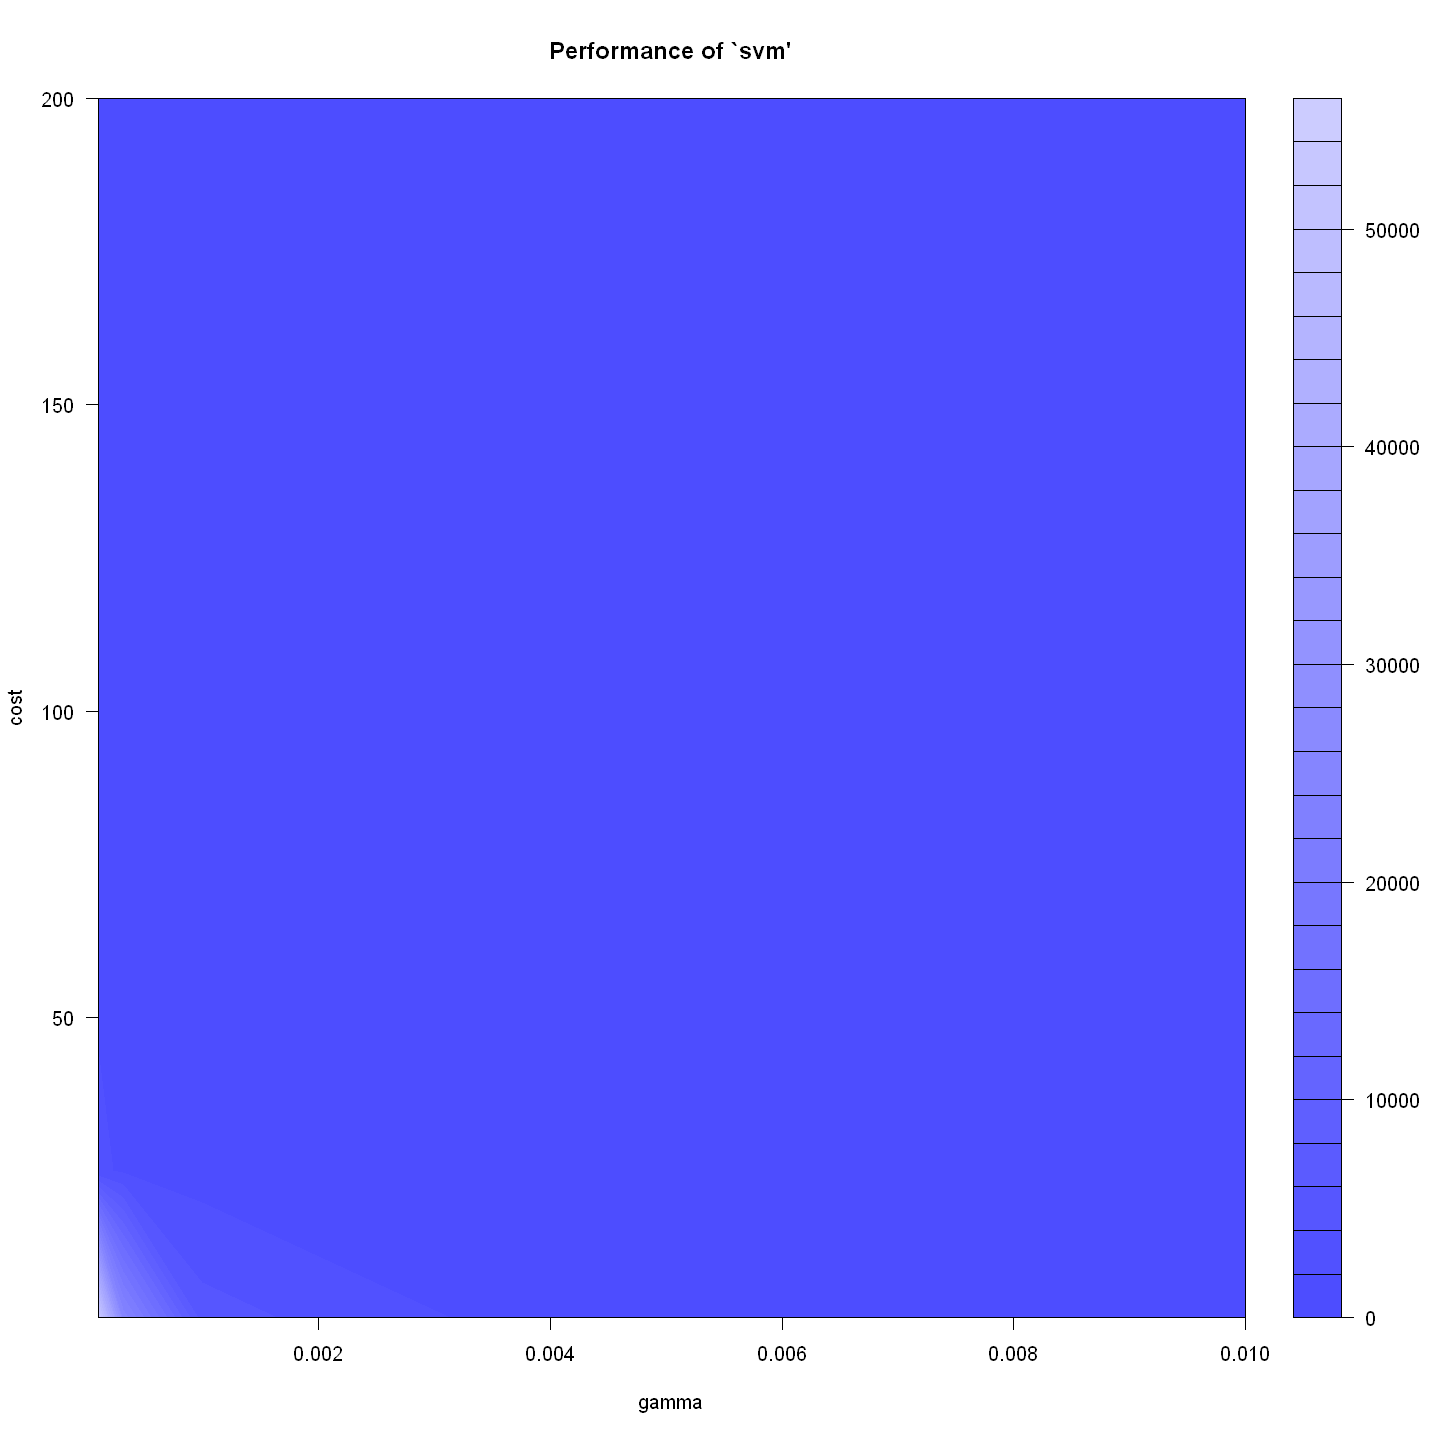

In [55]:
#tuning of linear kernel

svm.reg.tune = tune.svm(Calories_Burned ~ ., data = gym_train_scaled, cost = c(1, 25, 50, 75, 100, 150, 200), 
    gamma = 10^seq(-4, -2, by = 0.5))
plot(svm.reg.tune)
svm.reg.tune

In [73]:
# 1. Prédictions sur le test (déjà faites)
y_test <- gym_test_scaled$Calories_Burned
pred_svm <- pred.svm.reg

# 2. Somme des carrés des résidus (SSE)
sse <- sum((y_test - pred_svm)^2)

# 3. Somme des carrés totaux (SST)
sst <- sum((y_test - mean(y_test))^2)

# 4. Calcul du R2
R2_svm <- 1 - sse / sst

# 5. Affichage
cat("MSE sur test :", mean((y_test - pred_svm)^2), "\n")
cat("R2  sur test :", round(R2_svm, 3), "\n")

MSE sur test : 622.9531 
R2  sur test : 0.991 


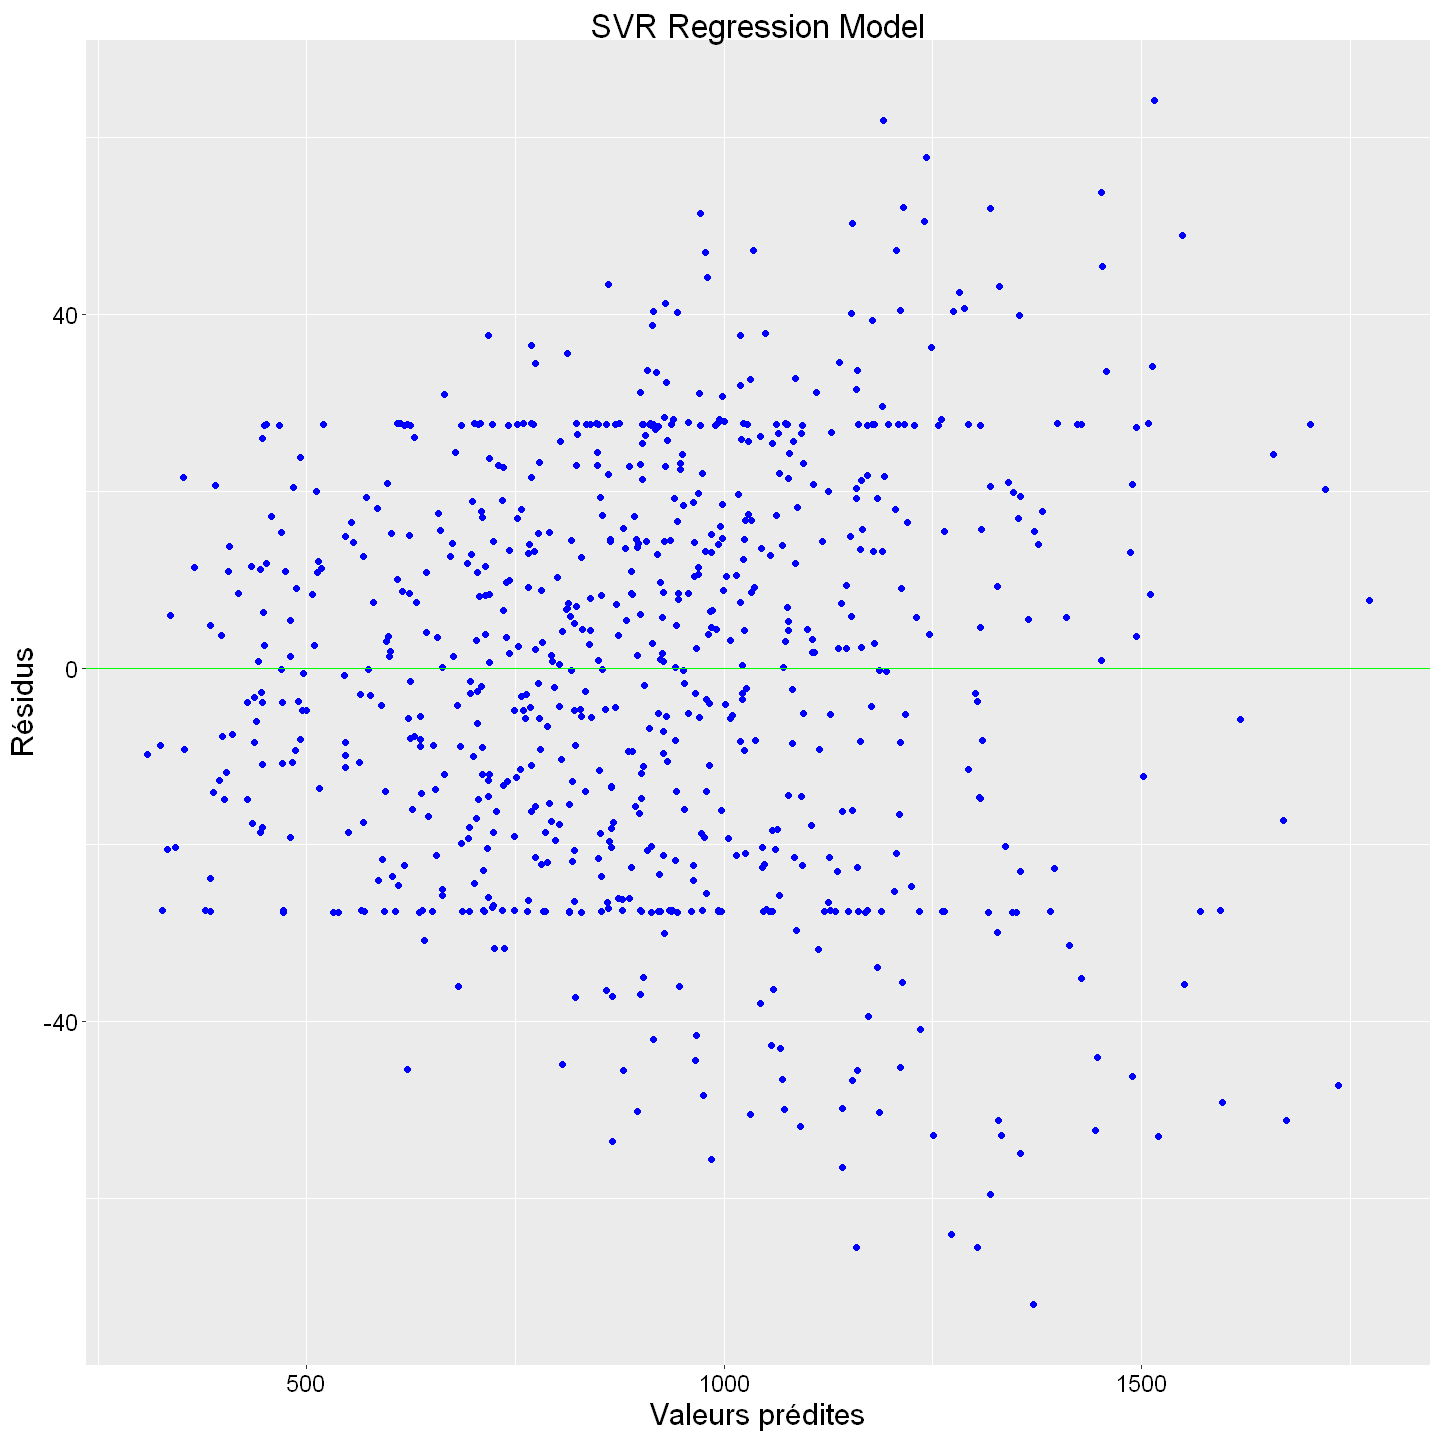

In [72]:
# graphe des résidus
fit.svm.reg = svm.reg$fitted
res.svm.reg = fit.svm.reg - gym_train_scaled$Calories_Burned
gplot.res(fit.svm.reg, res.svm.reg, "SVR Regression Model")

Un R² = 0,991 signifie que le modèle explique 99,1 % de la variance des calories brûlées.

Une MSE de 623 est très basse, signe d’une précision de prédiction élevée.

Autrement dit, l’erreur moyenne au carré sur les nouvelles données est de l’ordre de 600 unités, ce qui est excellent dans ce contexte.
Le Lasso quadratique reste légèrement en tête (R² ≃ 0,9927 vs 0,991 et MSE ≃ 570 vs 623). Mais vu sa complexité, nous allons plutôt priviliégier SVR à kernel radial.

### Réseaux de neurones : 

In [86]:
install.packages("caret")
install.packages("neuralnet")

Warning message:
"le package 'caret' est en cours d'utilisation et ne sera pas installé"
Installation du package dans 'C:/Users/essak/AppData/Local/R/win-library/4.3'
(car 'lib' n'est pas spécifié)



installation de la dépendance 'Deriv'




le package 'Deriv' a été décompressé et les sommes MD5 ont été vérifiées avec succés
le package 'neuralnet' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\essak\AppData\Local\Temp\RtmpyKHnMn\downloaded_packages


+ Fold1: size= 5, decay=1e-04 
- Fold1: size= 5, decay=1e-04 
+ Fold1: size=10, decay=1e-04 
- Fold1: size=10, decay=1e-04 
+ Fold1: size=15, decay=1e-04 
- Fold1: size=15, decay=1e-04 
+ Fold1: size= 5, decay=1e-03 
- Fold1: size= 5, decay=1e-03 
+ Fold1: size=10, decay=1e-03 
- Fold1: size=10, decay=1e-03 
+ Fold1: size=15, decay=1e-03 
- Fold1: size=15, decay=1e-03 
+ Fold1: size= 5, decay=1e-02 
- Fold1: size= 5, decay=1e-02 
+ Fold1: size=10, decay=1e-02 
- Fold1: size=10, decay=1e-02 
+ Fold1: size=15, decay=1e-02 
- Fold1: size=15, decay=1e-02 
+ Fold1: size= 5, decay=1e-01 
- Fold1: size= 5, decay=1e-01 
+ Fold1: size=10, decay=1e-01 
- Fold1: size=10, decay=1e-01 
+ Fold1: size=15, decay=1e-01 
- Fold1: size=15, decay=1e-01 
+ Fold2: size= 5, decay=1e-04 
- Fold2: size= 5, decay=1e-04 
+ Fold2: size=10, decay=1e-04 
- Fold2: size=10, decay=1e-04 
+ Fold2: size=15, decay=1e-04 
- Fold2: size=15, decay=1e-04 
+ Fold2: size= 5, decay=1e-03 
- Fold2: size= 5, decay=1e-03 
+ Fold2:

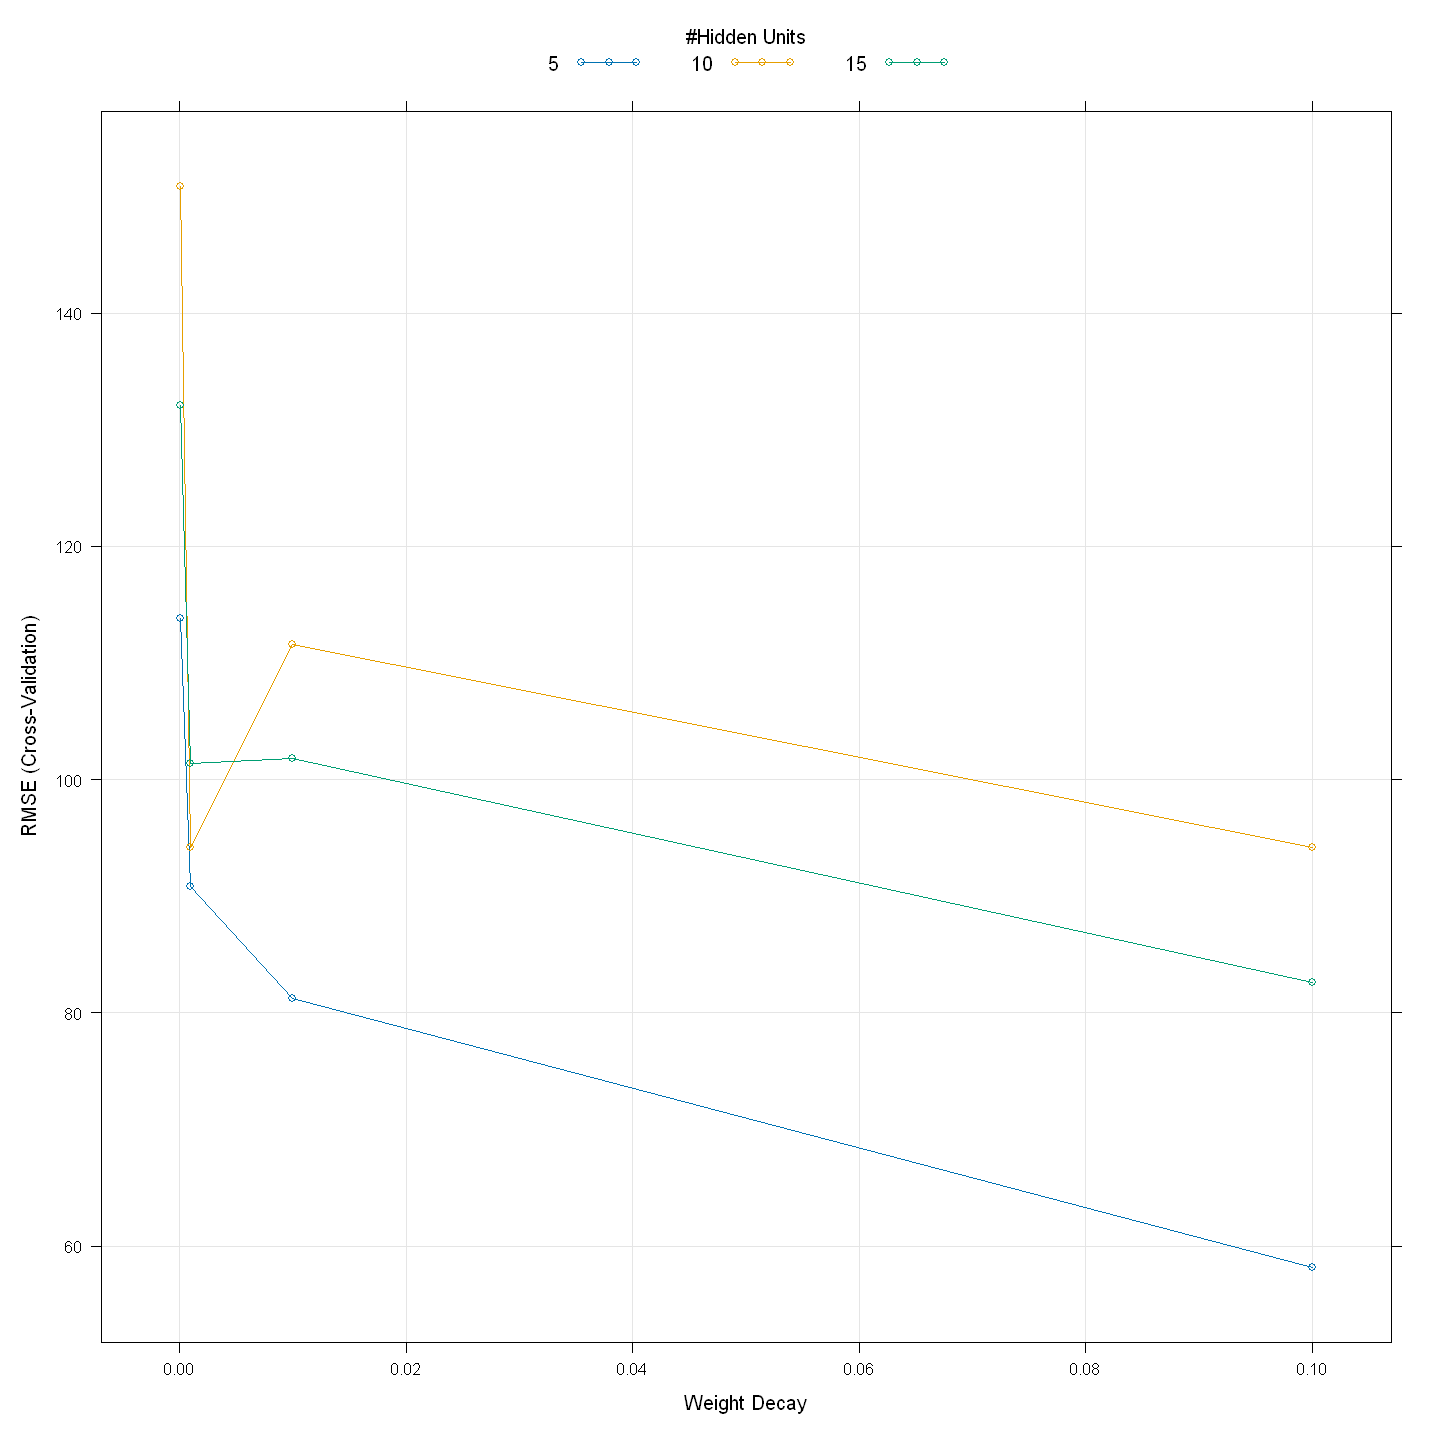

In [88]:
library(caret)
library(nnet)

# Define the grid of hyperparameters
tune_grid <- expand.grid(
    size = c(5, 10, 15),       # Number of neurons in the hidden layer
    decay = c(0.0001, 0.001, 0.01, 0.1)  # Regularization parameter
)

# Define cross-validation settings
ctrl <- trainControl(
    method = "cv",
    number = 5,                # 5-fold cross-validation
    verboseIter = TRUE
)

# Train the neural network model with hyperparameter tuning
set.seed(123)
nn_model <- train(
    Calories_Burned ~ .,
    data = gym_train_scaled,
    method = "nnet",
    linout = TRUE,             # For regression
    trace = FALSE,             # Disable logs
    maxit = 1000,              # Maximum iterations
    tuneGrid = tune_grid,
    trControl = ctrl,
    metric = "RMSE"            # Evaluation metric
)

# Display the best hyperparameters and plot the results
print(nn_model$bestTune)
plot(nn_model)


+ Fold1: size= 5, decay=1e-04 
- Fold1: size= 5, decay=1e-04 
+ Fold1: size=10, decay=1e-04 
- Fold1: size=10, decay=1e-04 
+ Fold1: size=15, decay=1e-04 
- Fold1: size=15, decay=1e-04 
+ Fold1: size= 5, decay=1e-03 
- Fold1: size= 5, decay=1e-03 
+ Fold1: size=10, decay=1e-03 
- Fold1: size=10, decay=1e-03 
+ Fold1: size=15, decay=1e-03 
- Fold1: size=15, decay=1e-03 
+ Fold1: size= 5, decay=1e-02 
- Fold1: size= 5, decay=1e-02 
+ Fold1: size=10, decay=1e-02 
- Fold1: size=10, decay=1e-02 
+ Fold1: size=15, decay=1e-02 
- Fold1: size=15, decay=1e-02 
+ Fold1: size= 5, decay=1e-01 
- Fold1: size= 5, decay=1e-01 
+ Fold1: size=10, decay=1e-01 
- Fold1: size=10, decay=1e-01 
+ Fold1: size=15, decay=1e-01 
- Fold1: size=15, decay=1e-01 
+ Fold2: size= 5, decay=1e-04 
- Fold2: size= 5, decay=1e-04 
+ Fold2: size=10, decay=1e-04 
- Fold2: size=10, decay=1e-04 
+ Fold2: size=15, decay=1e-04 
- Fold2: size=15, decay=1e-04 
+ Fold2: size= 5, decay=1e-03 
- Fold2: size= 5, decay=1e-03 
+ Fold2:

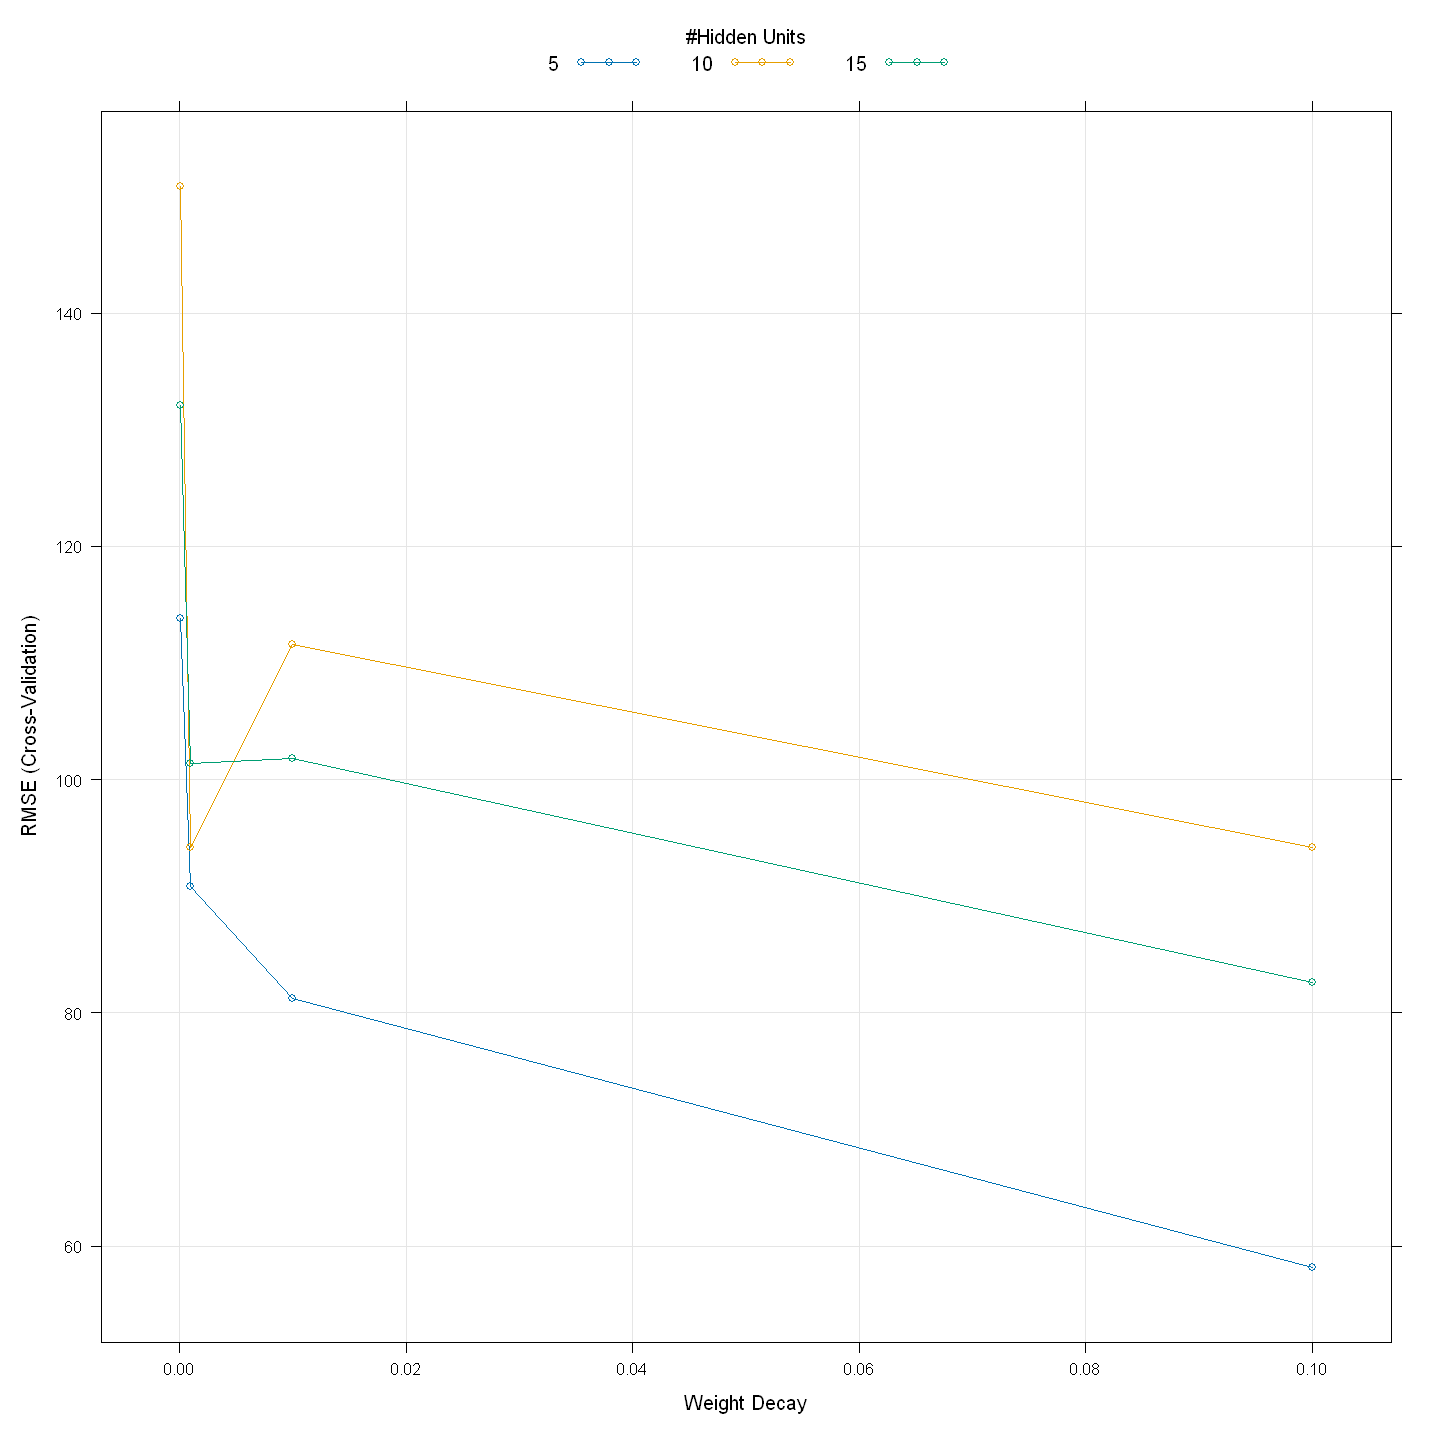

In [76]:
library(caret)
library(nnet)

# Configuration de la validation croisée (5 folds)
ctrl <- trainControl(
  method = "cv",
  number = 5,
  verboseIter = TRUE
)

# Grille d'hyperparamètres à explorer
tune_grid <- expand.grid(
  size = c(5, 10, 15),       # Nombre de neurones cachés
  decay = c(0.0001, 0.001, 0.01, 0.1)  # Force de régularisation
)

# Entraînement avec optimisation
set.seed(123)
model <- train(
  Calories_Burned ~ .,
  data = gym_train_scaled,
  method = "nnet",
  linout = TRUE,             # Pour la régression
  trace = FALSE,             # Désactive les logs
  maxit = 1000,              # Itérations maximales
  tuneGrid = tune_grid,
  trControl = ctrl,
  metric = "RMSE"            # Métrique d'évaluation
)

# Affichage des résultats
print(model$bestTune)
plot(model)

In [92]:
model$results

,size,decay,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,1e-04,113.83218,0.8071194,92.26653,50.87126,0.11606642,41.61250
2,5,1e-03,90.85086,0.8631162,72.24621,53.78057,0.11407205,43.06761
3,5,1e-02,81.20257,0.8947792,64.01849,47.35280,0.09619250,39.82279
4,5,1e-01,58.22114,0.9403608,44.28335,41.30900,0.08815511,32.49651
5,10,1e-04,150.82129,0.7031016,119.66775,20.11245,0.07872371,17.23814
6,10,1e-03,94.17313,0.8538238,75.60944,53.08351,0.11804180,43.58856
7,10,1e-02,111.59180,0.8156576,88.35732,44.83544,0.10328444,35.47179
8,10,1e-01,94.18435,0.8691801,72.90200,39.16916,0.09144797,30.81305
9,15,1e-04,132.06936,0.7561028,103.62841,39.21346,0.13659895,32.20002


In [77]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg <- nnet(Calories_Burned ~ ., data = gym_train_scaled, size = 15, decay = 0.1, linout = TRUE, maxit = 1000)
summary(nnet.reg)

# weights:  101


initial  value 700917355.161088 
iter  10 value 24466234.451607
iter  20 value 19516927.070375
iter  30 value 19080370.669872
iter  40 value 18842591.085422
iter  50 value 18808065.257935
iter  60 value 18792138.569982
iter  70 value 18473292.941956
iter  80 value 18332011.926308
iter  90 value 16227500.132115
iter 100 value 16130060.589624
iter 110 value 16001870.172116
iter 120 value 14518402.134364
iter 130 value 14378959.523258
iter 140 value 14201118.872623
iter 150 value 14060933.486332
iter 160 value 14012290.304384
iter 170 value 13991801.539527
iter 180 value 13984961.579881
iter 190 value 13983792.438164
iter 200 value 13980129.560916
iter 210 value 13943986.813688
iter 220 value 13889562.248125
iter 230 value 13883129.459507
iter 240 value 13867532.016295
iter 250 value 13865975.881845
iter 260 value 13358231.925773
iter 270 value 13108686.771652
iter 280 value 12532186.722009
iter 290 value 12402907.698626
iter 300 value 12332370.840613
iter 310 value 12321825.989065
iter 3

a 18-5-1 network with 101 weights
options were - linear output units  decay=0.1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   1.33   -0.13    0.22   -0.01    0.00    0.03    0.29   -0.01    1.22   -0.01 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 
  -0.05   -0.01   -0.01    0.02    0.02    0.06   -0.07    0.00   -0.05 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -65.51   -1.47   -0.43  -19.63    7.10  -27.84  -11.46  -17.12   12.91  -36.77 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 
 -26.84  -35.93  -13.53   55.10  -10.93   35.39   14.81   85.16   53.18 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  23.89   24.12  -17.32   17.87   -4.90  -49.72  -44.21   10.55   15.54   -6.59 
i10->h3 i11->h3 i12->h3 i13->h3 i14->h3 i15->h3 i16->h3 i17->h3 i18->h3 
  11.17   -4.45   54.01   13.94  -38.62  -39.80  -18.81   26.59   24.

Voici une interprétation des résultats obtenus sur la grille de réseaux de neurones (via `nnet` ou similaire), où l’on fait varier :

- **size** : nombre de neurones dans la couche cachée  
- **decay** : coefficient de régularisation (penalty L₂ sur les poids)

| size | decay  | RMSE    | R²       | MAE     | RMSESD  | R²SD    | MAESD  |
|------|--------|---------|----------|---------|---------|---------|--------|
| 5    | 1e-4   | 113.8   | 0.807    |  92.3   | 50.9    | 0.116   | 41.6   |
| 5    | 1e-3   |  90.9   | 0.863    |  72.2   | 53.8    | 0.114   | 43.1   |
| 5    | 1e-2   |  81.2   | 0.895    |  64.0   | 47.4    | 0.096   | 39.8   |
| 5    | 1e-1   | **58.2**| **0.940**| **44.3**| 41.3    | 0.088   | 32.5   |
| 10   | 1e-4   | 150.8   | 0.703    | 119.7   | 20.1    | 0.079   | 17.2   |
| 10   | 1e-3   |  94.2   | 0.854    |  75.6   | 53.1    | 0.118   | 43.6   |
| 10   | 1e-2   | 111.6   | 0.816    |  88.4   | 44.8    | 0.103   | 35.5   |
| 10   | 1e-1   |  94.2   | 0.869    |  72.9   | 39.2    | 0.091   | 30.8   |
| 15   | 1e-4   | 132.1   | 0.756    | 103.6   | 39.2    | 0.137   | 32.2   |
| 15   | 1e-3   | 101.4   | 0.864    |  78.6   | 20.4    | 0.052   | 16.5   |
| 15   | 1e-2   | 101.8   | 0.855    |  80.3   | 35.7    | 0.084   | 28.9   |
| 15   | 1e-1   |  82.6   | 0.895    |  66.2   | 40.9    | 0.089   | 32.6   |

---

### 1. Choix optimal de l’hyperparamètre
- **Meilleur couple (size, decay)** : **5 neurones** et **decay = 0,1**  
- **Performance associée** :  
  - **RMSE = 58,2** (le plus faible de la grille)  
  - **R² = 0,94** (le plus élevé)  
  - **MAE = 44,3**  

C’est donc un **modèle compact** (peu de neurones) avec une **régularisation modérée** qui offre la meilleure généralisation sur nos données.

---

### 2. Effets de la régularisation (decay)
- **Decay très faible** (1e-4) → sous-régularisation → **RMSE élevé** (>100), **R² bas** (~0,75–0,80).  
- **Augmentation progressive de decay** → diminution du RMSE et montée du R² jusqu’à un optimum à 0,1.  
- **Au-delà**, un decay trop fort (pour size 10 ou 15) ne fait pas mieux que le pic autour de 5×0,1.

---

### 3. Impact du nombre de neurones (size)
- **Réseau très petit** (size = 5) + bon decay : excellente performance.  
- **Réseaux plus gros** (size = 10 ou 15) n’apportent **pas** d’amélioration nette :  
  - Ils nécessitent souvent un réglage de decay fin, mais n’atteignent jamais les niveaux de RMSE/R² du petit réseau.  
  - Risque d’**overfitting** plus élevé (variabilité inter-fold plus importante).

---

### 4. Fiabilité & stabilité
- La **SD** des métriques (RMSESD, R²SD) reste raisonnable pour le couple optimal, témoignant d’une **performance stable** à travers les folds.

---

## Conclusion

Pour ce jeu de données :
- **Nous allons préférer un réseau à 5 neurones** avec **decay = 0,1**, qui minimise l’erreur (RMSE ≃ 58) et maximise l’explication de variance (R² ≃ 0,94).
- **Ni trop de neurones**, ni **trop peu de régularisation** : l’équilibre trouvé évite à la fois sous- et sur-apprentissage.
- Les architectures plus complexes (size ≥ 10) n’apportent pas de gain suffisant pour justifier l’augmentation de la complexité.